<a href="https://colab.research.google.com/github/arman-hossain-git/ML/blob/main/credit_card_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Context**<br>
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

**Content**<br>
The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

**The Dependencies**


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import time

import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
from scipy.stats import norm, skew, boxcox_normmax
from scipy.special import boxcox1p

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import sklearn
from sklearn import metrics
from sklearn import linear_model
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, classification_report, confusion_matrix, average_precision_score, precision_recall_curve

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, KFold, RepeatedKFold
from sklearn.linear_model import Ridge, Lasso, LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC

import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

import warnings
warnings.filterwarnings('ignore')

**Exploratory Data Analysis**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
df = pd.read_csv('gdrive/MyDrive/Colab Notebooks/creditcard.csv')

In [ ]:
#df = pd.read_csv(r'C:\Users\Arman\Downloads\creditcard.csv')

In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.shape

(284807, 31)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [ ]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [ ]:
df.groupby('Class')['Class'].count()

Class
0    284315
1       492
Name: Class, dtype: int64

In [ ]:
df['Class'].count()

np.int64(284807)

In [ ]:
print((df.groupby('Class')['Class'].count()/df['Class'].count())*100)

Class
0    99.827251
1     0.172749
Name: Class, dtype: float64


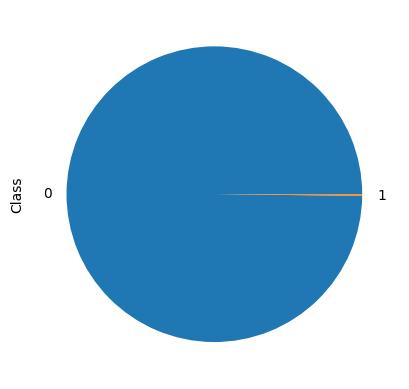

In [ ]:
((df.groupby('Class')['Class'].count()/df['Class'].count())*100).plot.pie();

In [ ]:
classes = df['Class'].value_counts()
normal_share = classes[0]/df['Class'].count()*100
fraud_share = classes[1]/df['Class'].count()*100

print(normal_share)
print(fraud_share)

99.82725143693798
0.1727485630620034


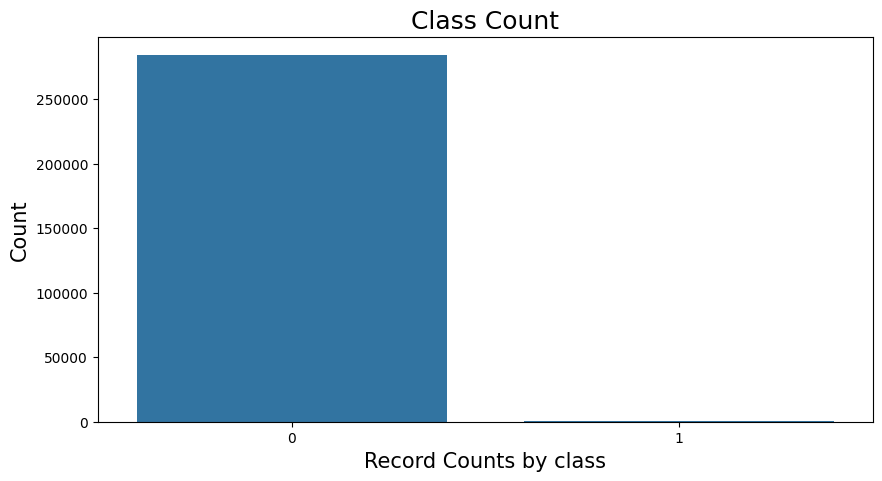

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x='Class', data=df)
plt.title("Class Count", fontsize=18)
plt.xlabel("Record Counts by class", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.show()

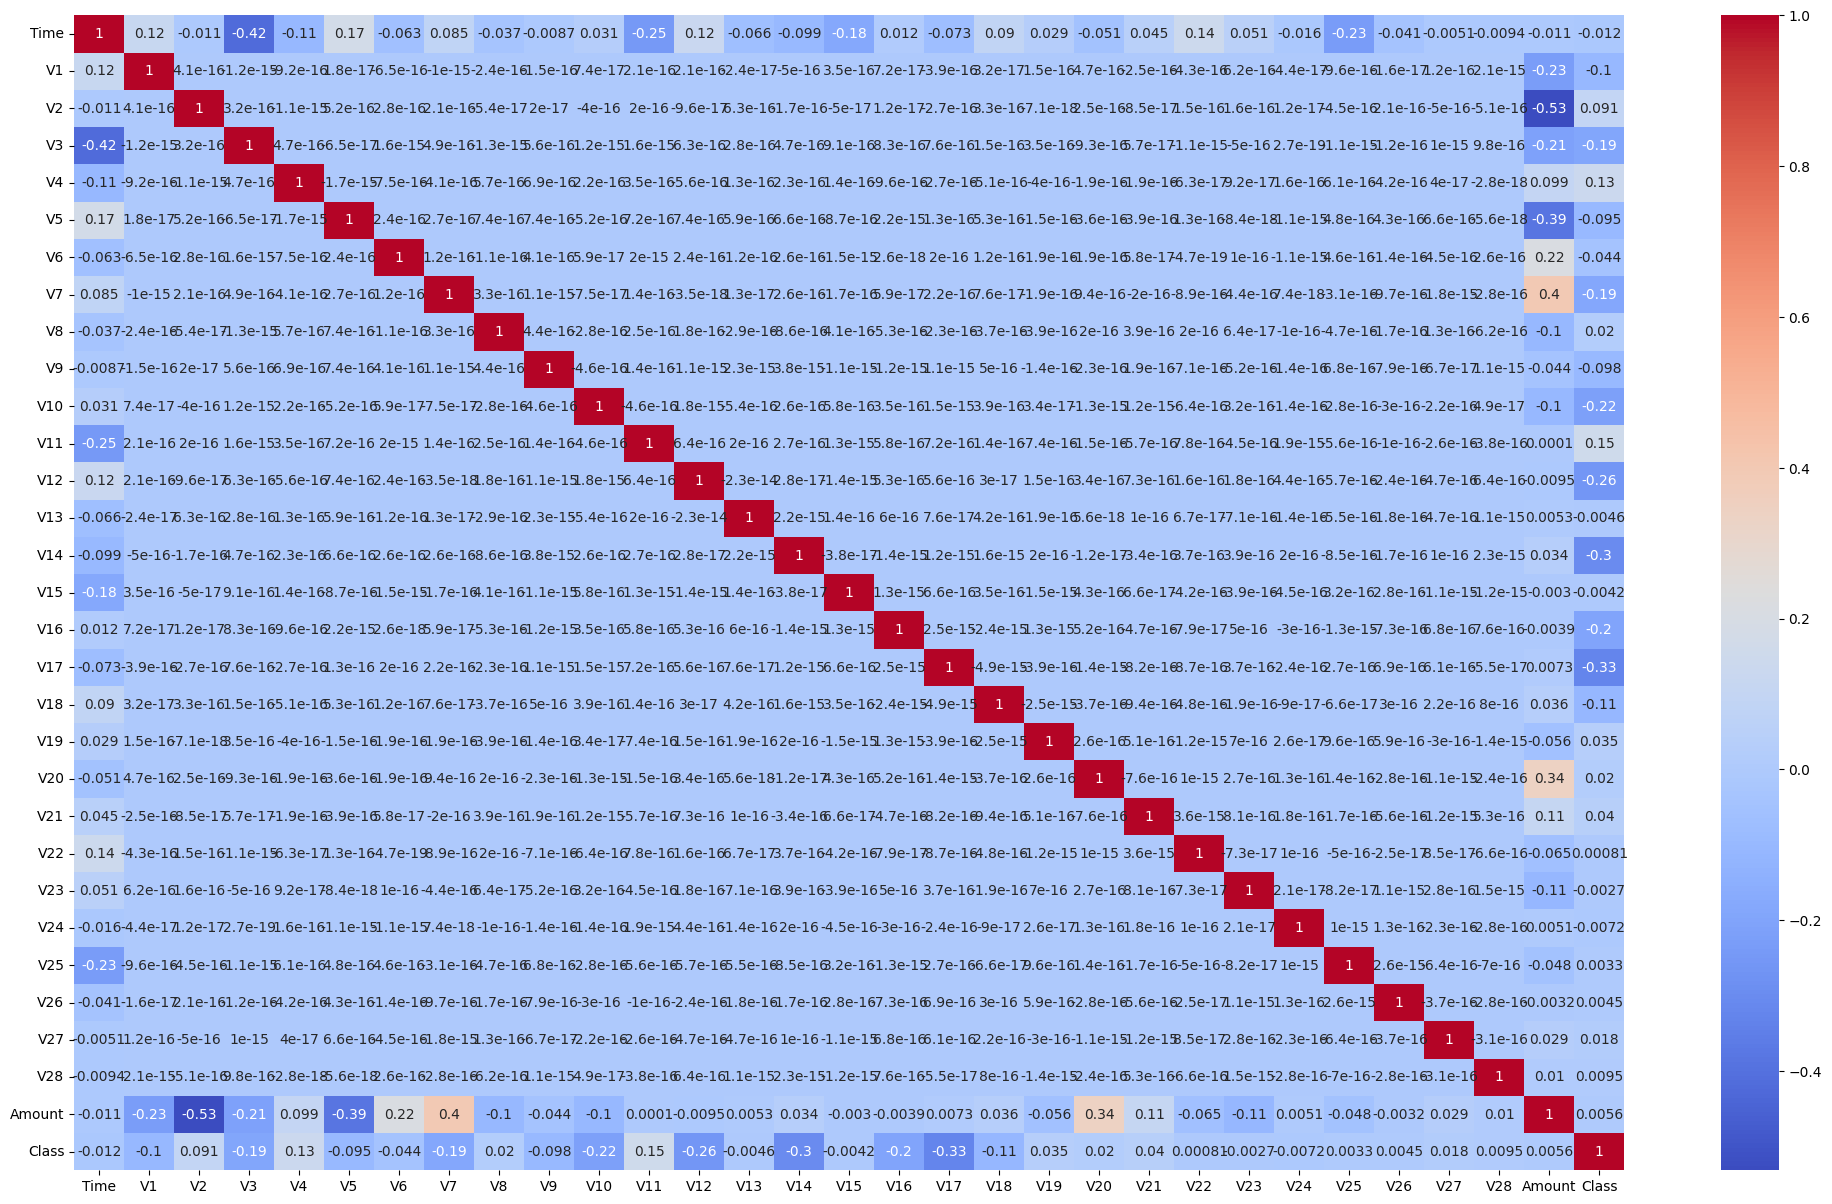

In [ ]:
corr = df.corr()
plt.figure(figsize=(25,15))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

**Feature Engineering**

In [ ]:
Delta_Time = pd.to_timedelta(df['Time'], unit='s')

df['Time_Day'] = (Delta_Time.dt.components.days).astype(int)
df['Time_Hour'] = (Delta_Time.dt.components.hours).astype(int)
df['Time_min'] = (Delta_Time.dt.components.minutes).astype(int)

In [ ]:
df.drop('Time', axis = 1, inplace = True)
df.drop(['Time_Day', 'Time_min'], axis = 1, inplace = True)

**Train-Test Split**

In [ ]:
y = df['Class']
X = df.drop(['Class'], axis = 1)

In [ ]:
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Time_Hour
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Class, dtype: int64

In [ ]:
y.shape

(284807,)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, test_size = 0.20)

In [ ]:
np.sum(y)

np.int64(492)

In [ ]:
np.sum(y_train)

np.int64(396)

In [ ]:
np.sum(y_test)

np.int64(96)

In [ ]:
cols = list(X.columns.values)

In [ ]:
cols

['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount',
 'Time_Hour']

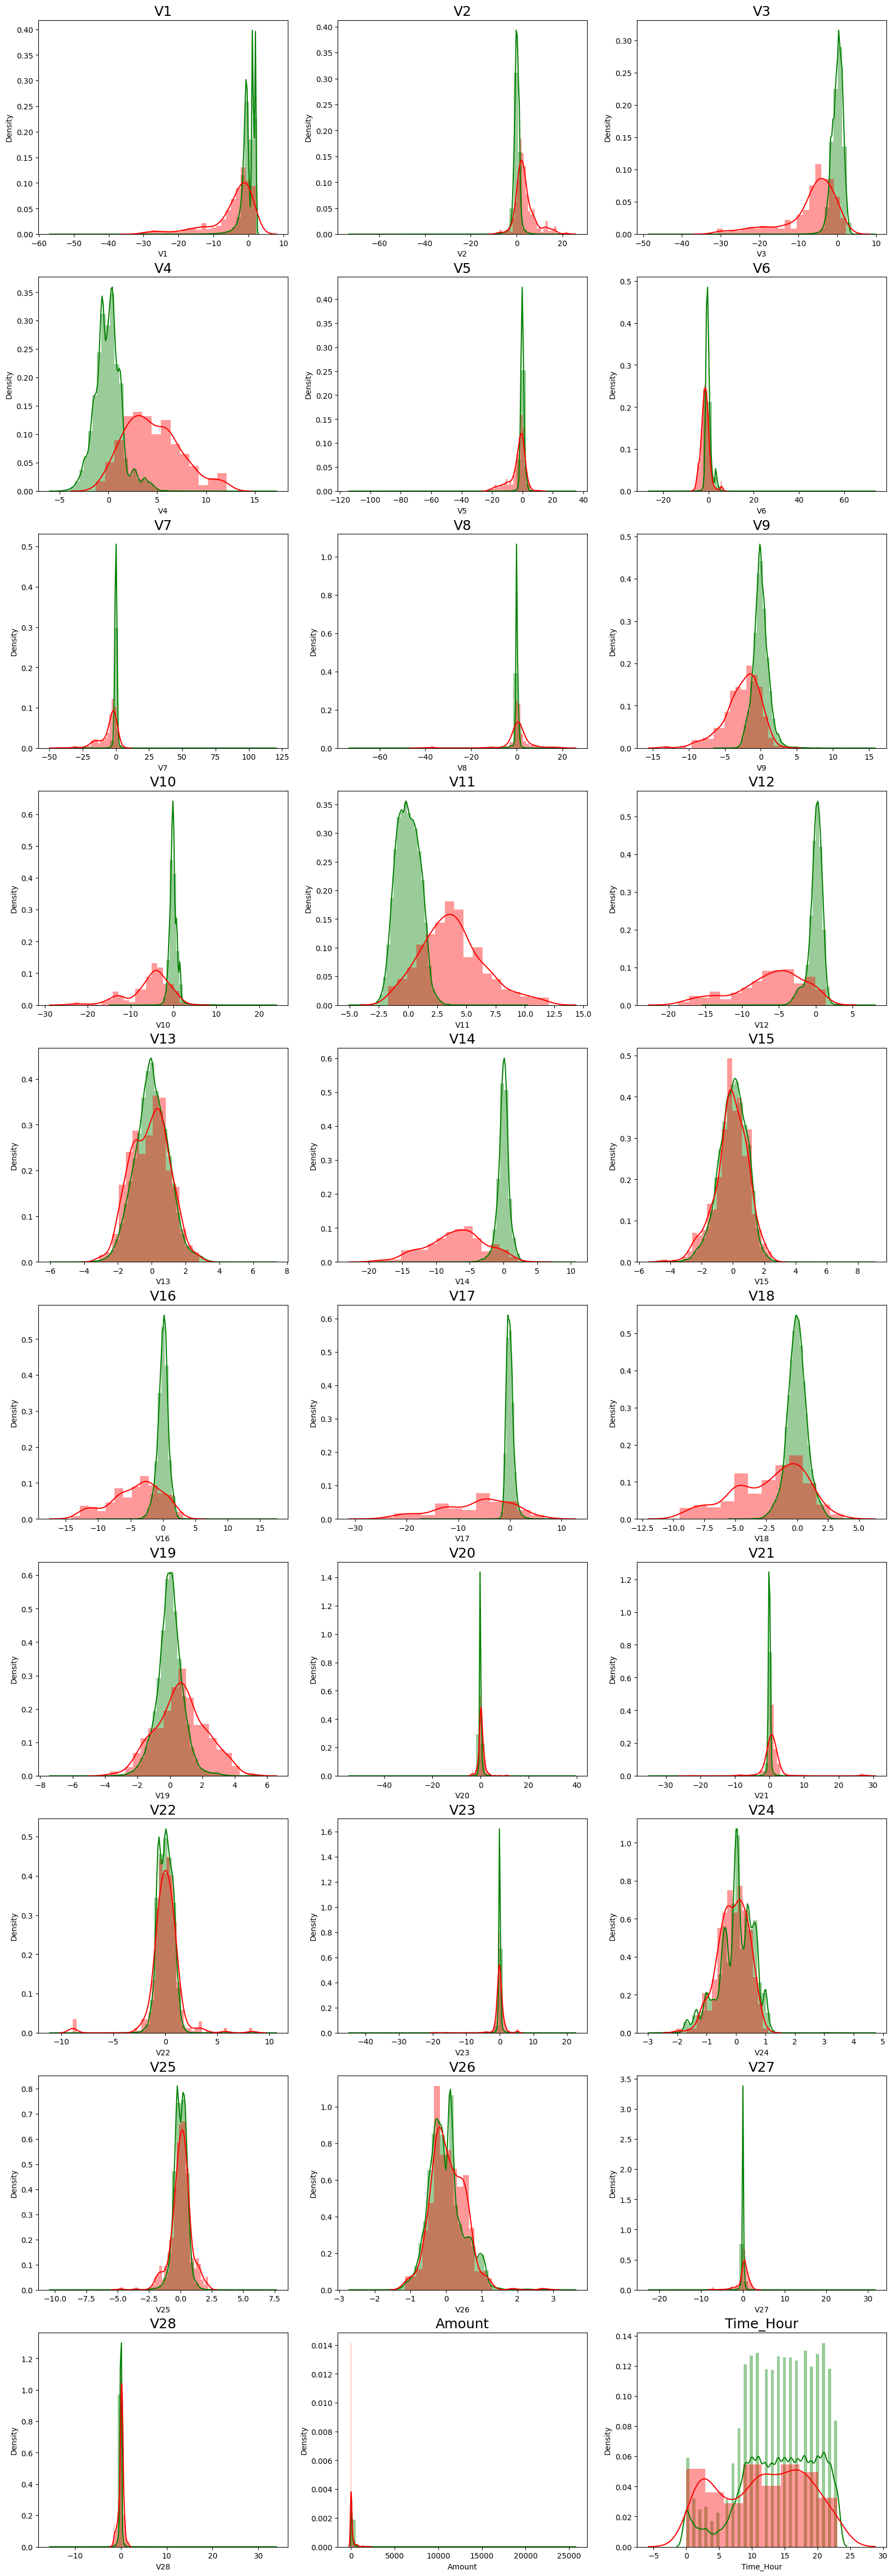

In [ ]:
normal_records = df.Class == 0
fraud_records = df.Class == 1

plt.figure(figsize=(20,60))

for n, col in enumerate(cols):
  plt.subplot(10,3,n+1)
  sns.distplot(X[col][normal_records], color='green')
  sns.distplot(X[col][fraud_records], color='red')
  plt.title(col, fontsize=18)
plt.show()

**Model Building**

In [ ]:
df_Results = pd.DataFrame(columns = ['Methodology', 'Model', 'Accuracy', 'roc_value', 'threshold'])

In [ ]:
# Confusion Metrix

def Plot_Confusion_Matrix(y_test, pred_test):
  cm = confusion_matrix(y_test, pred_test)
  plt.clf()
  plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Accent)
  categoryNames = ['Genuine', 'Fraud']
  plt.title('Test Data Confusion Matrix')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  ticks = np.arange(len(categoryNames))
  plt.xticks(ticks, categoryNames, rotation = 60)
  plt.yticks(ticks, categoryNames)
  s = [['TN', 'FP'], ['FN', 'TP']]

  for i in range(2):
    for j in range(2):
      plt.text(j,i,str(s[i][j])+" = "+str(cm[i][j]), fontsize=12)

  plt.show()

**Logistic Regression Model**

In [ ]:
def buildAndRunLogisticModels(df_Results, Methodology, X_train, y_train, X_test, y_test):

  num_C = list(np.power(10.0, np.arange(-10,10)))
  cv_num = KFold(n_splits = 10, shuffle = True, random_state = 42)

  searchCV_l1 = linear_model.LogisticRegressionCV(
      Cs = num_C,
      penalty = 'l1',
      scoring = 'roc_auc',
      cv = cv_num,
      random_state = 42,
      max_iter = 10000,
      fit_intercept = True,
      solver = 'liblinear',
      tol = 10
  )

  searchCV_l2 = linear_model.LogisticRegressionCV(
      Cs = num_C,
      penalty = 'l2',
      scoring = 'roc_auc',
      cv = cv_num,
      random_state = 42,
      max_iter = 10000,
      fit_intercept = True,
      solver = 'newton-cg',
      tol = 10
  )

  searchCV_l1.fit(X_train, y_train)
  searchCV_l2.fit(X_train, y_train)
  print('Max auc_roc for l1: ', searchCV_l1.scores_[1].mean(axis=0).max())
  print('Max auc_roc for l2: ', searchCV_l2.scores_[1].mean(axis=0).max())

  print("Parameters for l1 regularizations")
  print(searchCV_l1.coef_)
  print(searchCV_l1.intercept_)
  print(searchCV_l1.scores_)

  print("Parameters for l2 regularizations")
  print(searchCV_l2.coef_)
  print(searchCV_l2.intercept_)
  print(searchCV_l2.scores_)

  y_pred_l1 = searchCV_l1.predict(X_test)
  y_pred_l2 = searchCV_l2.predict(X_test)

  y_pred_probs_l1 = searchCV_l1.predict_proba(X_test)[:,1]
  y_pred_probs_l2 = searchCV_l2.predict_proba(X_test)[:,1]


  Accuracy_l2 = metrics.accuracy_score(y_pred=y_pred_l2, y_true=y_test)
  Accuracy_l1 = metrics.accuracy_score(y_pred=y_pred_l1, y_true=y_test)

  print("Accuracy of Logistic model with l2 regularization: {0}".format(Accuracy_l2))
  print("Confusion Matrix")
  Plot_Confusion_Matrix(y_test, y_pred_l2)
  print("Classification Report")
  print(classification_report(y_test, y_pred_l2))

  print("Accuracy of Logistic model with l1 regularization: {0}".format(Accuracy_l1))
  print("Confusion Matrix")
  Plot_Confusion_Matrix(y_test, y_pred_l1)
  print("Classification Report")
  print(classification_report(y_test, y_pred_l1))

  l2_roc_value = roc_auc_score(y_test, y_pred_probs_l2)
  print("l2 roc_value: {0}".format(l2_roc_value))
  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs_l2)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print("l2 threshold: {0}".format(threshold))

  roc_auc = metrics.auc(fpr, tpr)
  print("ROC for the test dataset", '{:.1%}'.format(roc_auc))
  plt.plot(fpr, tpr, label = "Test, auc="+str(roc_auc))
  plt.legend(loc=4)
  plt.show()

  #df_Results = df_Results.append(pd.DataFrame({'Methodology': Methodology, 'Model': 'Logistic Regression with L2 Regularization','Accuracy': Accuracy_l2, 'roc_value': l2_roc_value, 'threshold': threshold}, index=[0]), ignore_index = True)
  df_Results = pd.concat([df_Results, pd.DataFrame({'Methodology': Methodology, 'Model': 'Logistic Regression with L2 Regularization','Accuracy': Accuracy_l2, 'roc_value': l2_roc_value, 'threshold': threshold}, index=[0])], ignore_index = True)


  l1_roc_value = roc_auc_score(y_test, y_pred_probs_l1)
  print("l1 roc_value: {0}".format(l1_roc_value))
  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs_l1)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print("l1 threshold {0}".format(threshold))

  roc_auc = metrics.auc(fpr, tpr)
  print("ROC for the test dataset", '{:.1%}'.format(roc_auc))
  plt.plot(fpr, tpr, label = "Test, auc="+str(roc_auc))
  plt.legend(loc=4)
  plt.show()

  #df_Results = df_Results.append(pd.DataFrame({'Methodology': Methodology, 'Model': 'Logistic Regression with l1 Regularization', 'Accuracy': Accuracy_l1, 'roc_value': l1_roc_value, 'threshold': threshold}, index=[0]), ignore_index = True)
  df_Results = pd.concat([df_Results, pd.DataFrame({'Methodology': Methodology, 'Model': 'Logistic Regression with L1 Regularization', 'Accuracy': Accuracy_l1, 'roc_value': l1_roc_value, 'threshold': threshold}, index=[0])], ignore_index = True)

  return df_Results

**KNN Model**

In [ ]:
def buildAndRunKNNModels(df_Results, Methodology, X_train, y_train, X_test, y_test):

  knn = KNeighborsClassifier(n_neighbors = 5, n_jobs = 16)
  knn.fit(X_train, y_train)
  score = knn.score(X_test, y_test)
  print("Model Score")
  print(score)

  y_pred = knn.predict(X_test)
  KNN_Accuracy = metrics.accuracy_score(y_pred = y_pred, y_true = y_test)
  print("Confusion Matrix")
  Plot_Confusion_Matrix(y_test, y_pred)
  print("Classification Report")
  print(classification_report(y_test, y_pred))

  knn_probs = knn.predict_proba(X_test)[:, 1]

  knn_roc_value = roc_auc_score(y_test, knn_probs)
  print("KNN roc value: {0}".format(knn_roc_value))
  fpr, tpr, thresholds = metrics.roc_curve(y_test, knn_probs)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print("KNN threshold: {0}".format(threshold))

  roc_auc = metrics.auc(fpr, tpr)
  print("ROC for the test dataset", '{:.1%}'.format(roc_auc))
  plt.plot(fpr, tpr, label = "Test, auc="+str(roc_auc))
  plt.legend(loc=4)
  plt.show()

  #df_Results = df_Results.append(pd.DataFrame({'Methodology': Methodology, 'Model': 'KNN', 'Accuracy': score, 'roc_value': knn_roc_value, 'threshold': threshold}, index=[0]), ignore_index = True)
  df_Results = pd.concat([df_Results, pd.DataFrame({'Methodology': Methodology, 'Model': 'KNN','Accuracy': score, 'roc_value': knn_roc_value, 'threshold': threshold}, index=[0])], ignore_index = True)

  return df_Results

**Decision Tree Model**

In [ ]:
def buildAndRunDecisionTreeModels(df_Results, Methodology, X_train, y_train, X_test, y_test):
  criteria = ['gini', 'entropy']
  scores = {}

  for c in criteria:
    dt = DecisionTreeClassifier(criterion = c, random_state = 42)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    test_score = dt.score(X_test, y_test)
    tree_preds = dt.predict_proba(X_test)[:, 1]
    tree_roc_value = roc_auc_score(y_test, tree_preds)
    scores = test_score
    print(c + "score: {0}".format(test_score))
    print("Confusion Matrix")
    Plot_Confusion_Matrix(y_test, y_pred)
    print("Classification Report")
    print(classification_report(y_test, y_pred))
    print(c + "tree_roc_value: {0}".format(tree_roc_value))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, tree_preds)
    threshold = thresholds[np.argmax(tpr-fpr)]
    print("Tree threshold: {0}".format(threshold))
    roc_auc = metrics.auc(fpr, tpr)
    print("ROC for the test dataset", '{:.1%}'.format(roc_auc))
    plt.plot(fpr, tpr, label = "Test, auc="+str(roc_auc))
    plt.legend(loc=4)
    plt.show()

    #df_Results = df_Results.append(pd.DataFrame({'Methodology': Methodology, 'Model': 'Tree Model with {0} criteria'.format(c), 'Accuracy': test_score, 'roc_value': tree_roc_value, 'threshold': threshold}, index=[0]), ignore_index = True)
    df_Results = pd.concat([df_Results, pd.DataFrame({'Methodology': Methodology, 'Model': 'Tree Model with {0} criteria'.format(c),'Accuracy': test_score, 'roc_value': tree_roc_value, 'threshold': threshold}, index=[0])], ignore_index = True)

  return df_Results

**Random Forest Model**

In [ ]:
def buildAndRunRandomForestModels(df_Results, Methodology, X_train, y_train, X_test, y_test):

  RF_model = RandomForestClassifier(n_estimators = 100,
                                    bootstrap = True,
                                    max_features = 'sqrt',
                                    random_state = 42)
  RF_model.fit(X_train, y_train)
  RF_test_score = RF_model.score(X_test, y_test)
  RF_model.predict(X_test)

  print('MOdel Accuracy: {0}'.format(RF_test_score))

  RF_predictions = RF_model.predict(X_test)

  print("Confusion Matrix")
  Plot_Confusion_Matrix(y_test, RF_predictions)
  print("Classification Report")
  print(classification_report(y_test, RF_predictions))

  RF_probs = RF_model.predict_proba(X_test)[:,1]

  RF_roc_value = roc_auc_score(y_test, RF_probs)

  print("Random Forest roc_value: {0}".format(RF_roc_value))
  fpr, tpr, thresholds = metrics.roc_curve(y_test, RF_probs)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print("Random Forest threshold: {0}".format(threshold))
  RF_roc_auc = metrics.auc(fpr, tpr)
  print("ROC for the test dataset", '{:.1%}'.format(RF_roc_auc))
  plt.plot(fpr, tpr, label="Test, auc="+str(RF_roc_auc))
  plt.legend(loc=4)
  plt.show()

  #df_Results = df_Results.append(pd.DataFrame({'Methodology': Methodology, 'Model': 'Random Forest', 'Accuracy': RF_test_score, 'roc_value': RF_roc_value, 'threshold': threshold}, index=[0]), ignore_index = True)
  df_Results = pd.concat([df_Results, pd.DataFrame({'Methodology': Methodology, 'Model': 'Random Forest','Accuracy': RF_test_score, 'roc_value': RF_roc_value, 'threshold': threshold}, index=[0])], ignore_index = True)

  return df_Results

In [ ]:
def buildAndRunXGBoostModels(df_Results, Methodology, X_train, y_train, X_test, y_test):

  XGBmodel = XGBClassifier(random_state = 42)
  XGBmodel.fit(X_train, y_train)
  y_pred = XGBmodel.predict(X_test)

  XGB_test_score = XGBmodel.score(X_test, y_test)
  print('Model Accuracy: {0}'.format(XGB_test_score))

  print("Confusion Matrix")
  Plot_Confusion_Matrix(y_test, y_pred)
  print("Classification Report")
  print(classification_report(y_test, y_pred))

  XGB_probs = XGBmodel.predict_proba(X_test)[:, 1]

  XGB_roc_value = roc_auc_score(y_test, XGB_probs)
  print("XGboost roc_value: {0}".format(XGB_roc_value))

  fpr, tpr, thresholds = metrics.roc_curve(y_test, XGB_probs)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print("XGboost threshold: {0}".format(threshold))

  XGB_roc_auc = metrics.auc(fpr, tpr)
  print("ROC for the test dataset", '{:.1%}'.format(XGB_roc_auc))

  plt.plot(fpr, tpr, label = "Test, auc="+str(XGB_roc_auc))
  plt.legend(loc=4)
  plt.show()

  #df_Results = df_Results.append(pd.DataFrame({'Methodology': Methodology, 'Model': 'XGBoost', 'Accuracy': XGB_test_score, 'roc_value': XGB_roc_value, 'threshold': threshold}, index=[0]), ignore_index = True)
  df_Results = pd.concat([df_Results, pd.DataFrame({'Methodology': Methodology, 'Model': 'XGBoost', 'Accuracy': XGB_test_score, 'roc_value': XGB_roc_value, 'threshold': threshold}, index=[0])], ignore_index = True)

  return df_Results

**SVM Model**

In [ ]:
def buildAndRunSVMModels(df_Results, Methodology, X_train, y_train, X_test, y_test):

  SVMmodel = SVC(kernel = 'sigmoid', random_state = 42)
  SVMmodel.fit(X_train, y_train)
  y_pred = SVMmodel.predict(X_test)

  SVM_score = accuracy_score(y_test, y_pred)
  print("Model Accuracy: {0}".format(SVM_score))

  print("Confusion Matrix")
  Plot_Confusion_Matrix(y_test, y_pred)
  print("Classification Report")
  print(classification_report(y_test, y_pred))

  classifier = SVC(kernel = 'sigmoid', probability = True)
  SVM_probs = classifier.fit(X_train, y_train).predict_proba(X_test)[:, 1]

  SVM_roc_value = roc_auc_score(y_test, SVM_probs)
  print("SVM roc_value: {0}".format(SVM_roc_value))

  fpr, tpr, thresholds = metrics.roc_curve(y_test, SVM_probs)
  threshold = thresholds[np.argmax(tpr-fpr)]
  print("SVM threshold: {0}".format(threshold))

  SVM_roc_auc = metrics.auc(fpr, tpr)
  print("ROC for the test dataset", '{:.1%}'.format(SVM_roc_auc))

  plt.plot(fpr, tpr, label = "Test, auc="+str(SVM_roc_auc))
  plt.legend(loc=4)
  plt.show()

  #df_Results = df_Results.append(pd.DataFrame({'Methodology': Methodology, 'Model': 'SVMmodel', 'Accuracy': SVM_score, 'roc_value': SVM_roc_value, 'threshold': threshold}, index=[0]), ignore_index = True)
  df_Results = pd.concat([df_Results, pd.DataFrame({'Methodology': Methodology, 'Model': 'SVMmodel','Accuracy': SVM_score, 'roc_value': SVM_roc_value, 'threshold': threshold}, index=[0])], ignore_index = True)

  return df_Results

**Cross Validation with RepeatedKFold**

In [ ]:
rkf = RepeatedKFold(n_splits = 5, n_repeats = 10, random_state = None)
for train_index, test_index in rkf.split(X,y):
  print("Train: ", train_index, " Test: ", test_index)
  X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
  y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

Train:  [     0      1      2 ... 284804 284805 284806]  Test:  [     4     26     27 ... 284771 284792 284796]
Train:  [     0      3      4 ... 284804 284805 284806]  Test:  [     1      2      5 ... 284793 284798 284802]
Train:  [     0      1      2 ... 284804 284805 284806]  Test:  [     7      9     11 ... 284784 284794 284797]
Train:  [     1      2      3 ... 284802 284803 284804]  Test:  [     0      8     10 ... 284801 284805 284806]
Train:  [     0      1      2 ... 284802 284805 284806]  Test:  [     3     15     16 ... 284800 284803 284804]
Train:  [     0      1      2 ... 284801 284802 284803]  Test:  [     9     11     20 ... 284804 284805 284806]
Train:  [     0      1      2 ... 284804 284805 284806]  Test:  [     6     19     21 ... 284788 284797 284798]
Train:  [     0      1      2 ... 284804 284805 284806]  Test:  [     4      7      8 ... 284780 284787 284794]
Train:  [     4      6      7 ... 284804 284805 284806]  Test:  [     0      1      2 ... 284796 284800 

Logistic Regression with L1 and L2 Regularization
Max auc_roc for l1:  0.9709135634829551
Max auc_roc for l2:  0.5761348073409861
Parameters for l1 regularizations
[[-0.05669135 -0.13129675 -0.18203105  0.06499811 -0.26084484  0.09262011
   0.11863008 -0.03282968 -0.14397612 -0.14360718 -0.0358098   0.01030979
  -0.13722418 -0.22296464  0.01339938 -0.11513778 -0.22696741  0.02590727
   0.00677277  0.22950562  0.09206587 -0.02830264 -0.0211192  -0.01164745
  -0.03466854 -0.0013649  -0.05127337 -0.00568011 -0.00649308 -0.11663783]]
[-2.09958712]
{np.int64(1): array([[0.5       , 0.5       , 0.5       , 0.5       , 0.52546048,
        0.54801791, 0.57136995, 0.90693212, 0.90084547, 0.91459957,
        0.88412866, 0.89345754, 0.91073967, 0.91173946, 0.90172277,
        0.90888143, 0.89084658, 0.90118676, 0.92791817, 0.93427177],
       [0.5       , 0.5       , 0.5       , 0.5       , 0.5835401 ,
        0.59340341, 0.60577666, 0.87498403, 0.9427893 , 0.93662205,
        0.92459009, 0.92768

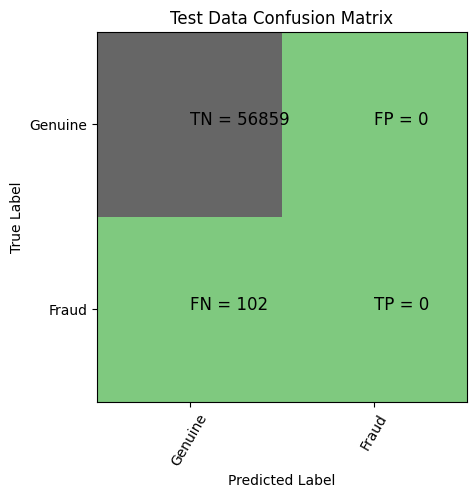

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56859
           1       0.00      0.00      0.00       102

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961

Accuracy of Logistic model with l1 regularization: 0.9988764242200804
Confusion Matrix


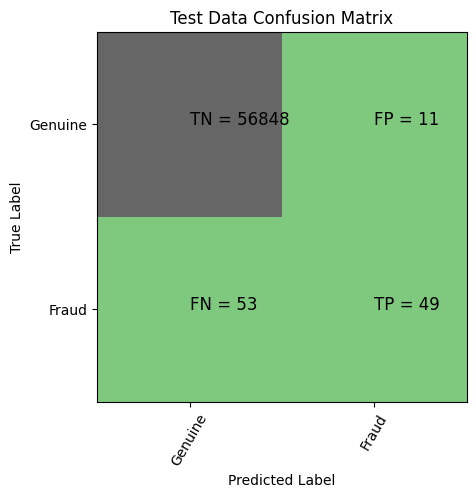

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56859
           1       0.82      0.48      0.60       102

    accuracy                           1.00     56961
   macro avg       0.91      0.74      0.80     56961
weighted avg       1.00      1.00      1.00     56961

l2 roc_value: 0.5303311356023793
l2 threshold: 0.49927681192135354
ROC for the test dataset 53.0%


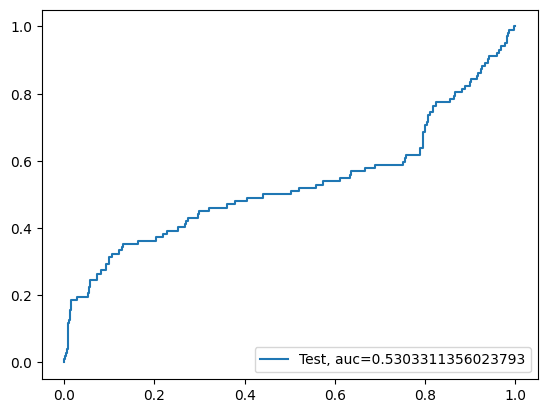

l1 roc_value: 0.8471368286669916
l1 threshold 0.04484406518272394
ROC for the test dataset 84.7%


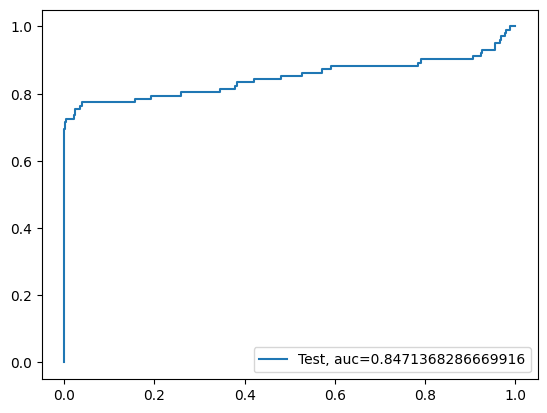

Time Taken by Model--- 104.18174600601196 seconds ---
------------------------------------------------------------


In [ ]:
#Run Logistic Regression with L1 and L2 Regularization

print("Logistic Regression with L1 and L2 Regularization")
start_time = time.time()
df_Results = buildAndRunLogisticModels(df_Results, "RepeatedKFold Cross Validation", X_train_cv, y_train_cv, X_test_cv, y_test_cv)
print("Time Taken by Model--- %s seconds ---" % (time.time() - start_time))
print('-'*60)

KNN Model
Model Score
0.9991748740366215
Confusion Matrix


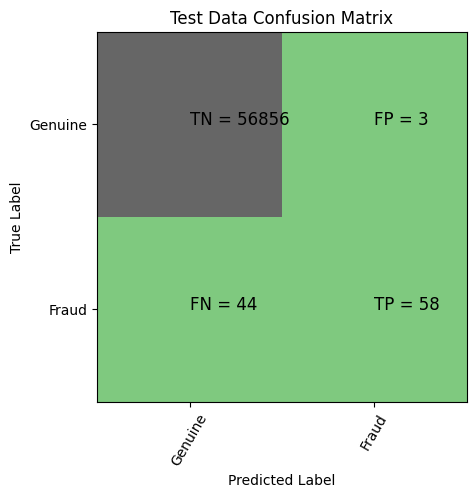

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56859
           1       0.95      0.57      0.71       102

    accuracy                           1.00     56961
   macro avg       0.98      0.78      0.86     56961
weighted avg       1.00      1.00      1.00     56961

KNN roc value: 0.8429605191238457
KNN threshold: 0.2
ROC for the test dataset 84.3%


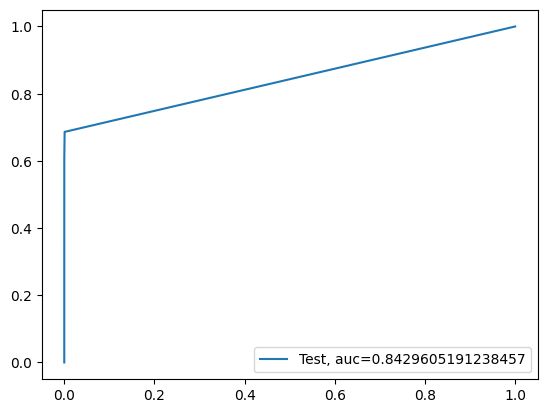

Time Taken by Model--- 141.8818552494049 seconds ---
------------------------------------------------------------


In [ ]:
#Run KNN Model

print("KNN Model")
start_time = time.time()
df_Results = buildAndRunKNNModels(df_Results, "RepeatedKFold Cross Validation", X_train_cv, y_train_cv, X_test_cv, y_test_cv)
print("Time Taken by Model--- %s seconds ---" % (time.time() - start_time))
print('-'*60)

Decision Tree Model
giniscore: 0.9991222064219378
Confusion Matrix


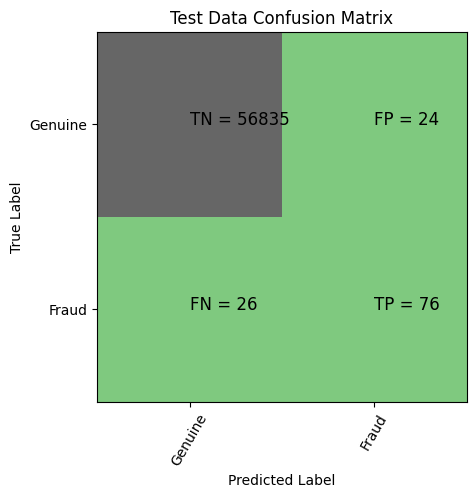

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56859
           1       0.76      0.75      0.75       102

    accuracy                           1.00     56961
   macro avg       0.88      0.87      0.88     56961
weighted avg       1.00      1.00      1.00     56961

ginitree_roc_value: 0.8723379712250015
Tree threshold: 1.0
ROC for the test dataset 87.2%


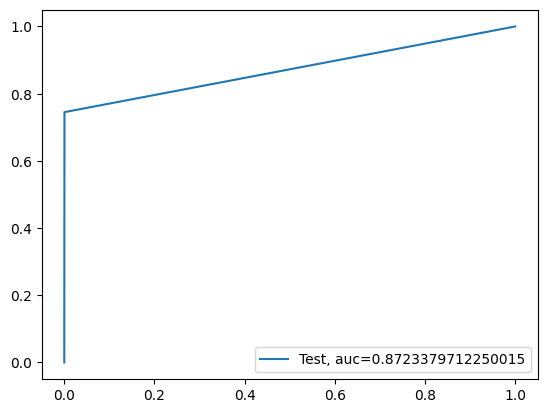

entropyscore: 0.999280209265989
Confusion Matrix


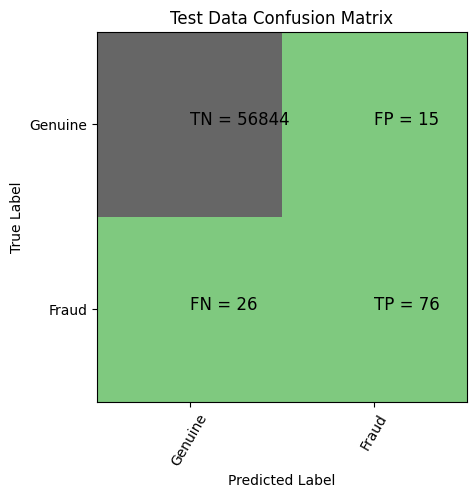

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56859
           1       0.84      0.75      0.79       102

    accuracy                           1.00     56961
   macro avg       0.92      0.87      0.89     56961
weighted avg       1.00      1.00      1.00     56961

entropytree_roc_value: 0.8724171143685671
Tree threshold: 1.0
ROC for the test dataset 87.2%


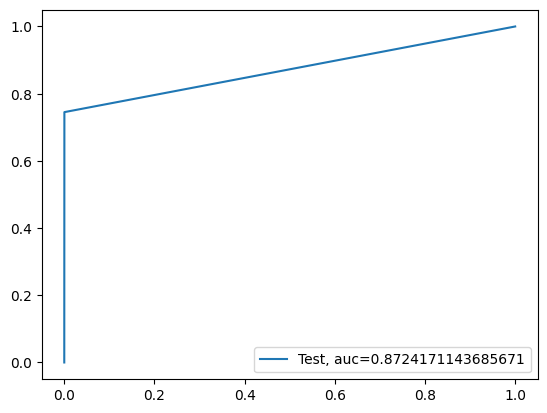

Time Taken by Model--- 42.92636799812317 seconds ---
------------------------------------------------------------


In [ ]:
#Run Decision Tree Model

print("Decision Tree Model")
start_time = time.time()
df_Results = buildAndRunDecisionTreeModels(df_Results, "RepeatedKFold Cross Validation", X_train_cv, y_train_cv, X_test_cv, y_test_cv)
print("Time Taken by Model--- %s seconds ---" % (time.time() - start_time))
print('-'*60)

Random Forest Model
MOdel Accuracy: 0.9994557679816014
Confusion Matrix


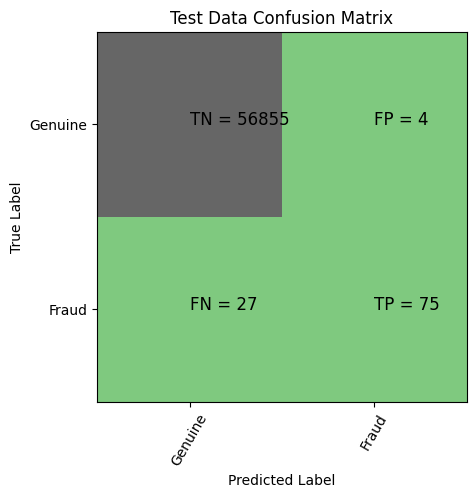

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56859
           1       0.95      0.74      0.83       102

    accuracy                           1.00     56961
   macro avg       0.97      0.87      0.91     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest roc_value: 0.9540923212528825
Random Forest threshold: 0.01
ROC for the test dataset 95.4%


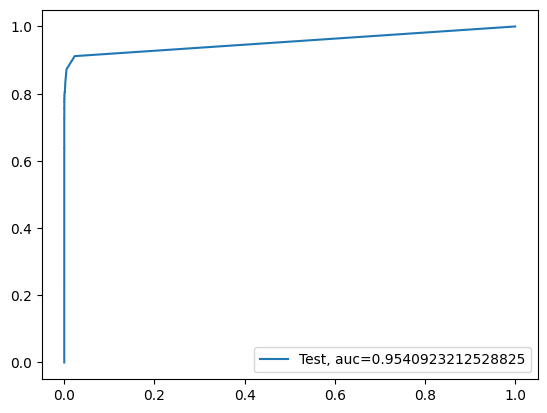

Time Taken by Model--- 266.1807827949524 seconds ---
------------------------------------------------------------


In [ ]:
#Run Random Forest Model

print("Random Forest Model")
start_time = time.time()
df_Results = buildAndRunRandomForestModels(df_Results, "RepeatedKFold Cross Validation", X_train_cv, y_train_cv, X_test_cv, y_test_cv)
print("Time Taken by Model--- %s seconds ---" % (time.time() - start_time))
print('-'*60)

SVM Model
Model Accuracy: 0.9982268569723144
Confusion Matrix


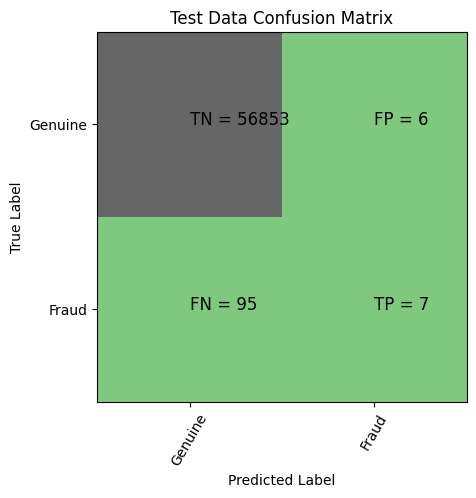

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56859
           1       0.54      0.07      0.12       102

    accuracy                           1.00     56961
   macro avg       0.77      0.53      0.56     56961
weighted avg       1.00      1.00      1.00     56961

SVM roc_value: 0.4954615976431551
SVM threshold: 0.0016863841183365244
ROC for the test dataset 49.5%


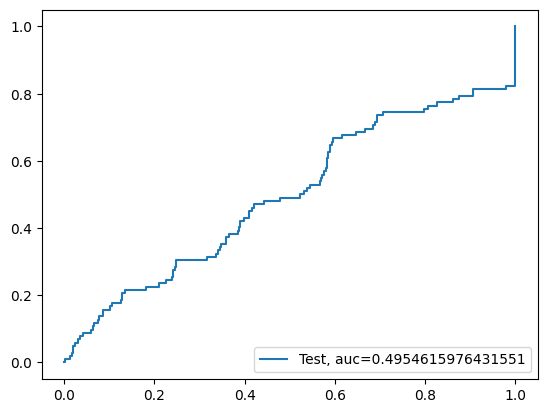

Time Taken by Model--- 1298.2514696121216 seconds ---
------------------------------------------------------------


In [ ]:
#Run SVM Model

print("SVM Model")
start_time = time.time()
df_Results = buildAndRunSVMModels(df_Results, "RepeatedKFold Cross Validation", X_train_cv, y_train_cv, X_test_cv, y_test_cv)
print("Time Taken by Model--- %s seconds ---" % (time.time() - start_time))
print('-'*60)


XGBoost Model
Model Accuracy: 0.9995259914678464
Confusion Matrix


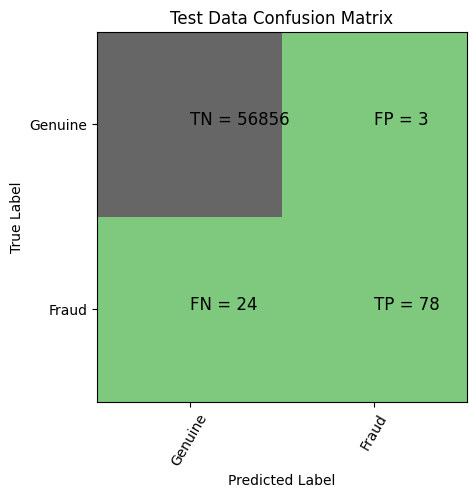

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56859
           1       0.96      0.76      0.85       102

    accuracy                           1.00     56961
   macro avg       0.98      0.88      0.93     56961
weighted avg       1.00      1.00      1.00     56961

XGboost roc_value: 0.9719686710400581
XGboost threshold: 3.49070796801243e-05
ROC for the test dataset 97.2%


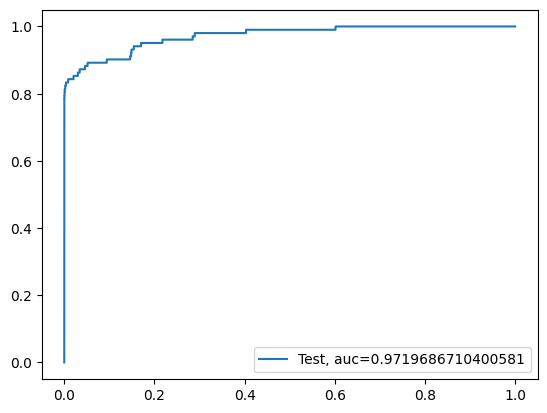

Time Taken by Model--- 4.603771686553955 seconds ---
------------------------------------------------------------


In [ ]:
#Run XGBoost Model

print("XGBoost Model")
start_time = time.time()
df_Results = buildAndRunXGBoostModels(df_Results, "RepeatedKFold Cross Validation", X_train_cv, y_train_cv, X_test_cv, y_test_cv)
print("Time Taken by Model--- %s seconds ---" % (time.time() - start_time))
print('-'*60)


In [ ]:
df_Results

,Methodology,Model,Accuracy,roc_value,threshold
0,RepeatedKFold Cross Validation,Logistic Regression with L2 Regularization,0.998209,0.530331,0.499277
1,RepeatedKFold Cross Validation,Logistic Regression with L1 Regularization,0.998876,0.847137,0.044844
2,RepeatedKFold Cross Validation,KNN,0.999175,0.842961,0.200000
3,RepeatedKFold Cross Validation,Tree Model with gini criteria,0.999122,0.872338,1.000000
4,RepeatedKFold Cross Validation,Tree Model with entropy criteria,0.999280,0.872417,1.000000
5,RepeatedKFold Cross Validation,Random Forest,0.999456,0.954092,0.010000
6,RepeatedKFold Cross Validation,SVMmodel,0.998227,0.495462,0.001686
7,RepeatedKFold Cross Validation,XGBoost,0.999526,0.971969,0.000035


Cross Validation with **StratifiedKFold**

In [ ]:
skf = StratifiedKFold(n_splits = 5, random_state = None)
for train_index, test_index in skf.split(X,y):
  print("Train: ", train_index, " Test: ", test_index)
  X_train_SKF_cv, X_test_SKF_cv = X.iloc[train_index], X.iloc[test_index]
  y_train_SKF_cv, y_test_SKF_cv = y.iloc[train_index], y.iloc[test_index]

Train:  [ 30473  30496  31002 ... 284804 284805 284806]  Test:  [    0     1     2 ... 57017 57018 57019]
Train:  [     0      1      2 ... 284804 284805 284806]  Test:  [ 30473  30496  31002 ... 113964 113965 113966]
Train:  [     0      1      2 ... 284804 284805 284806]  Test:  [ 81609  82400  83053 ... 170946 170947 170948]
Train:  [     0      1      2 ... 284804 284805 284806]  Test:  [150654 150660 150661 ... 227866 227867 227868]
Train:  [     0      1      2 ... 227866 227867 227868]  Test:  [212516 212644 213092 ... 284804 284805 284806]


Logistic Regression Model
Max auc_roc for l1:  0.9652106893977332
Max auc_roc for l2:  0.5597020083683936
Parameters for l1 regularizations
[[-0.03660539 -0.1358827  -0.20474594  0.04333662 -0.24034598  0.08416903
   0.12654905 -0.04815306 -0.14258132 -0.1384162  -0.11668372  0.05505155
  -0.15637116 -0.24216184 -0.03137093 -0.09904364 -0.23133976  0.05582481
   0.02122044  0.20503748  0.09013502  0.00148754 -0.03796378 -0.00392139
  -0.14797782 -0.00701001 -0.06594801 -0.00660368 -0.00656465 -0.12981985]]
[-2.0409044]
{np.int64(1): array([[0.5       , 0.5       , 0.5       , 0.5       , 0.48341269,
        0.44979055, 0.48500892, 0.78098262, 0.9497821 , 0.94525947,
        0.91827811, 0.91446679, 0.94989144, 0.94933682, 0.94178407,
        0.94900653, 0.92481293, 0.94421561, 0.9164553 , 0.97793244],
       [0.5       , 0.5       , 0.5       , 0.5       , 0.54612019,
        0.57709187, 0.60597219, 0.84651057, 0.93343227, 0.93465714,
        0.92629828, 0.92557122, 0.94481541, 0.932985

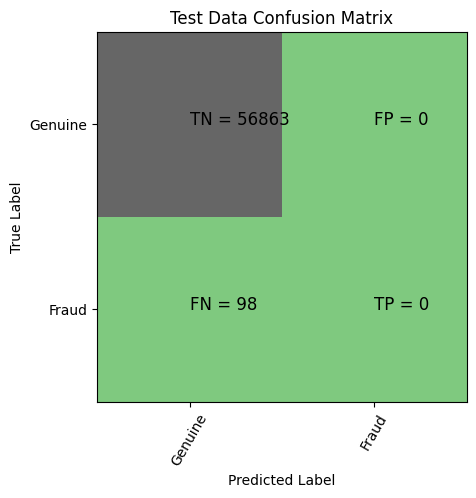

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961

Accuracy of Logistic model with l1 regularization: 0.9987535331191517
Confusion Matrix


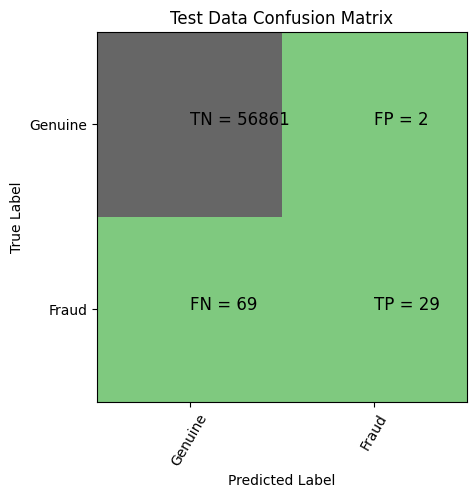

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.94      0.30      0.45        98

    accuracy                           1.00     56961
   macro avg       0.97      0.65      0.72     56961
weighted avg       1.00      1.00      1.00     56961

l2 roc_value: 0.6111619154810686
l2 threshold: 0.4993921957728672
ROC for the test dataset 61.1%


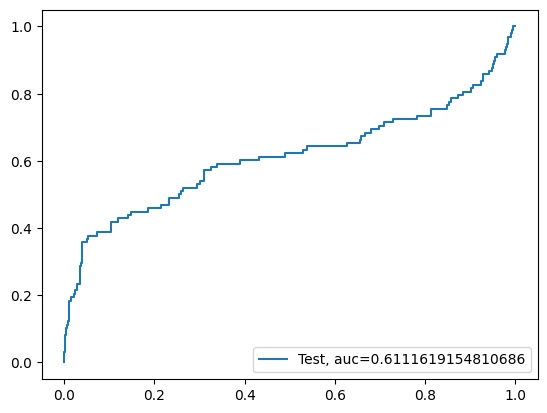

l1 roc_value: 0.8890758561483437
l1 threshold 0.021087492766199856
ROC for the test dataset 88.9%


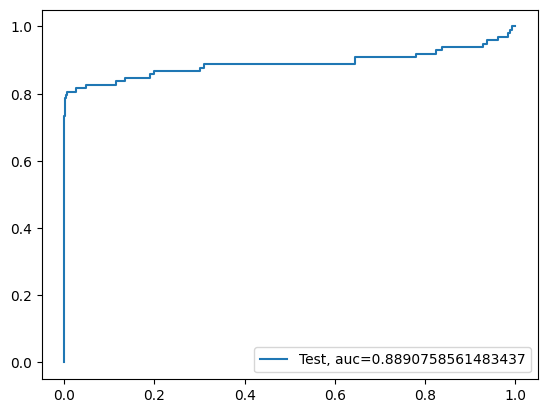

Time Taken by Model--- 126.99778771400452 seconds ---
------------------------------------------------------------


In [ ]:
#Run Logistic Regression Model

print("Logistic Regression Model")
start_time = time.time()
df_Results = buildAndRunLogisticModels(df_Results, "StratifiedKFold Cross Validation", X_train_SKF_cv, y_train_SKF_cv, X_test_SKF_cv, y_test_SKF_cv)
print("Time Taken by Model--- %s seconds ---" % (time.time() - start_time))
print('-'*60)

KNN Model
Model Score
0.9991924299081828
Confusion Matrix


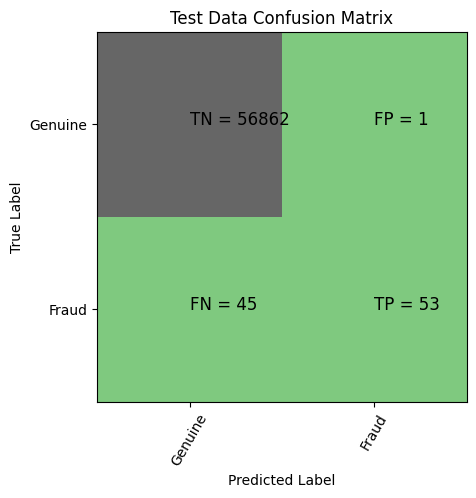

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.98      0.54      0.70        98

    accuracy                           1.00     56961
   macro avg       0.99      0.77      0.85     56961
weighted avg       1.00      1.00      1.00     56961

KNN roc value: 0.8057457828285457
KNN threshold: 0.2
ROC for the test dataset 80.6%


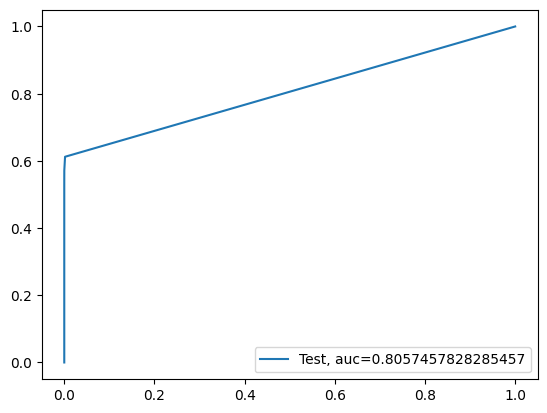

Time Taken by Model--- 194.0359923839569 seconds ---
------------------------------------------------------------


In [ ]:
#Run KNN Model

print("KNN Model")
start_time = time.time()
df_Results = buildAndRunKNNModels(df_Results, "StratifiedKFold Cross Validation", X_train_SKF_cv, y_train_SKF_cv, X_test_SKF_cv, y_test_SKF_cv)
print("Time Taken by Model--- %s seconds ---" % (time.time() - start_time))
print('-'*60)

Decision Tree Model
giniscore: 0.998841312476958
Confusion Matrix


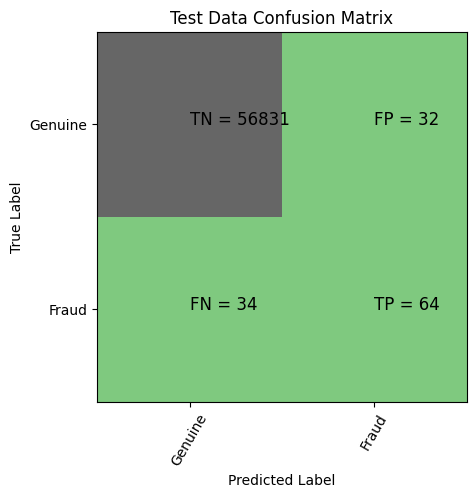

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.67      0.65      0.66        98

    accuracy                           1.00     56961
   macro avg       0.83      0.83      0.83     56961
weighted avg       1.00      1.00      1.00     56961

ginitree_roc_value: 0.8262492341959029
Tree threshold: 1.0
ROC for the test dataset 82.6%


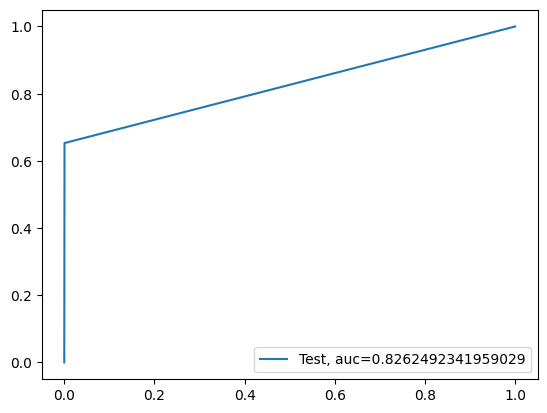

entropyscore: 0.9990168711925703
Confusion Matrix


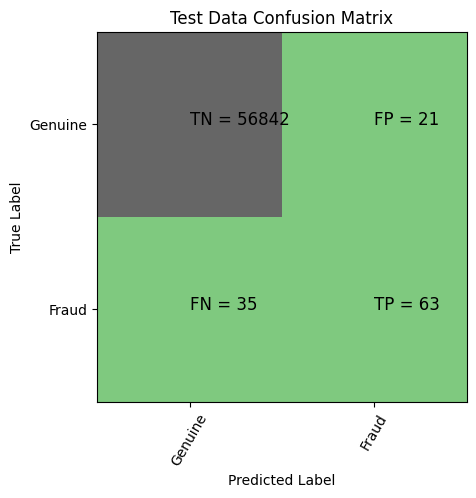

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.75      0.64      0.69        98

    accuracy                           1.00     56961
   macro avg       0.87      0.82      0.85     56961
weighted avg       1.00      1.00      1.00     56961

entropytree_roc_value: 0.8212439170839185
Tree threshold: 1.0
ROC for the test dataset 82.1%


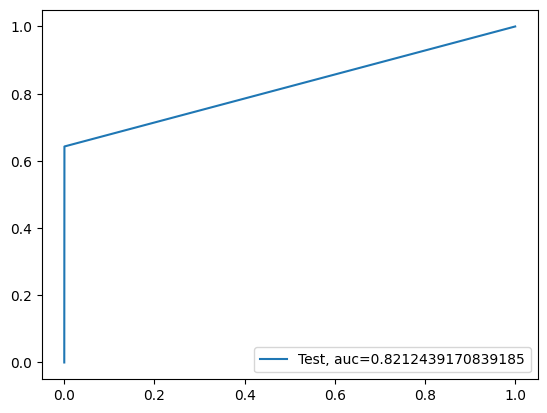

Time Taken by Model--- 56.04540276527405 seconds ---
------------------------------------------------------------


In [ ]:
#Run Decision Tree Model

print("Decision Tree Model")
start_time = time.time()
df_Results = buildAndRunDecisionTreeModels(df_Results, "StratifiedKFold Cross Validation", X_train_SKF_cv, y_train_SKF_cv, X_test_SKF_cv, y_test_SKF_cv)
print("Time Taken by Model--- %s seconds ---" % (time.time() - start_time))
print('-'*60)

Random Forest Model
MOdel Accuracy: 0.9994382121100402
Confusion Matrix


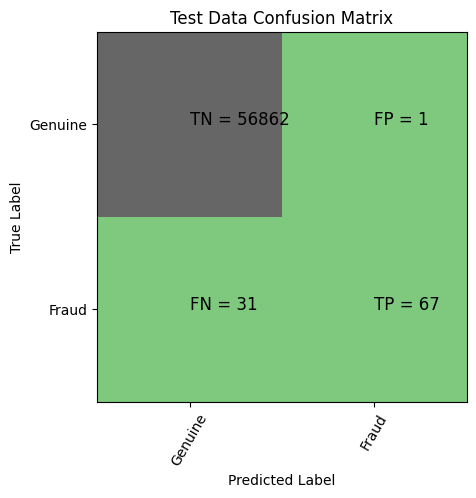

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.99      0.68      0.81        98

    accuracy                           1.00     56961
   macro avg       0.99      0.84      0.90     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest roc_value: 0.9464721329855826
Random Forest threshold: 0.01
ROC for the test dataset 94.6%


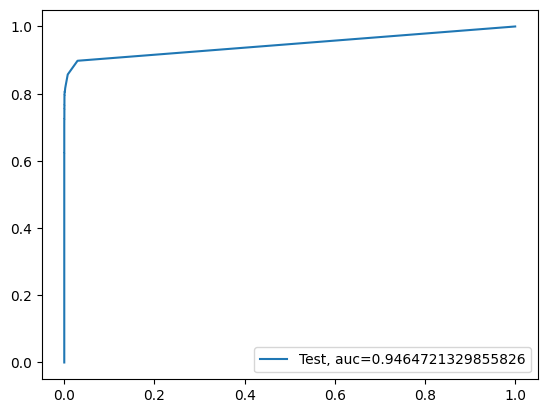

Time Taken by Model--- 311.8527579307556 seconds ---
------------------------------------------------------------


In [ ]:
#Run Random Forest Model

print("Random Forest Model")
start_time = time.time()
df_Results = buildAndRunRandomForestModels(df_Results, "StratifiedKFold Cross Validation", X_train_SKF_cv, y_train_SKF_cv, X_test_SKF_cv, y_test_SKF_cv)
print("Time Taken by Model--- %s seconds ---" % (time.time() - start_time))
print('-'*60)

XGBoost Model
Model Accuracy: 0.9994382121100402
Confusion Matrix


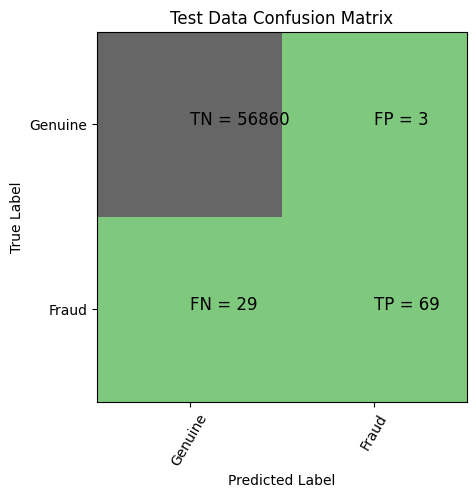

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.96      0.70      0.81        98

    accuracy                           1.00     56961
   macro avg       0.98      0.85      0.91     56961
weighted avg       1.00      1.00      1.00     56961

XGboost roc_value: 0.9722049451474309
XGboost threshold: 3.768169699469581e-05
ROC for the test dataset 97.2%


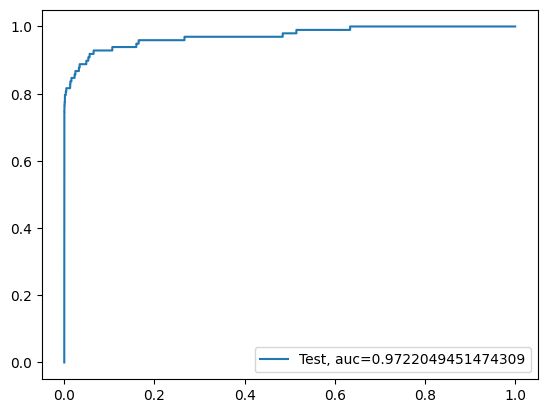

Time Taken by Model--- 5.150667905807495 seconds ---
------------------------------------------------------------


In [ ]:
#Run XGBoost Model

print("XGBoost Model")
start_time = time.time()
df_Results = buildAndRunXGBoostModels(df_Results, "StratifiedKFold Cross Validation", X_train_SKF_cv, y_train_SKF_cv, X_test_SKF_cv, y_test_SKF_cv)
print("Time Taken by Model--- %s seconds ---" % (time.time() - start_time))
print('-'*60)

SVM Model
Model Accuracy: 0.9982795245869981
Confusion Matrix


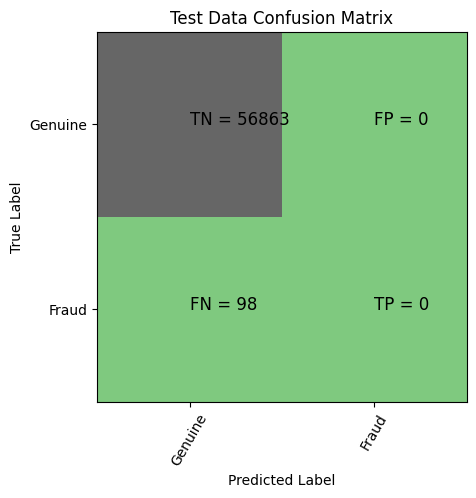

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961

SVM roc_value: 0.40177034885494567
SVM threshold: 0.003094697020273688
ROC for the test dataset 40.2%


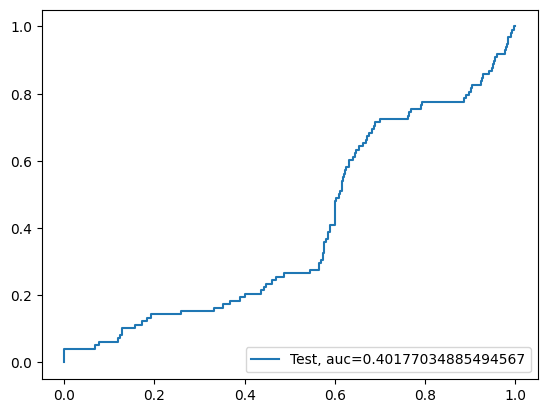

Time Taken by Model--- 237.47263598442078 seconds ---
------------------------------------------------------------


In [ ]:
#Run SVM Model

print("SVM Model")
start_time = time.time()
df_Results = buildAndRunSVMModels(df_Results, "StratifiedKFold Cross Validation", X_train_SKF_cv, y_train_SKF_cv, X_test_SKF_cv, y_test_SKF_cv)
print("Time Taken by Model--- %s seconds ---" % (time.time() - start_time))
print('-'*60)

In [ ]:
df_Results

,Methodology,Model,Accuracy,roc_value,threshold
0,RepeatedKFold Cross Validation,Logistic Regression with L2 Regularization,0.998209,0.530331,0.499277
1,RepeatedKFold Cross Validation,Logistic Regression with L1 Regularization,0.998876,0.847137,0.044844
2,RepeatedKFold Cross Validation,KNN,0.999175,0.842961,0.200000
3,RepeatedKFold Cross Validation,Tree Model with gini criteria,0.999122,0.872338,1.000000
4,RepeatedKFold Cross Validation,Tree Model with entropy criteria,0.999280,0.872417,1.000000
5,RepeatedKFold Cross Validation,Random Forest,0.999456,0.954092,0.010000
6,RepeatedKFold Cross Validation,SVMmodel,0.998227,0.495462,0.001686
7,RepeatedKFold Cross Validation,XGBoost,0.999526,0.971969,0.000035
8,StratifiedKFold Cross Validation,Logistic Regression with L2 Regularization,0.998280,0.611162,0.499392
9,StratifiedKFold Cross Validation,Logistic Regression with L1 Regularization,0.998754,0.889076,0.021087


In [ ]:
XGBmodel = XGBClassifier(random_state = 42)
XGBmodel.fit(X_train_SKF_cv, y_train_SKF_cv)
y_pred = XGBmodel.predict(X_test)

XGB_test_score = XGBmodel.score(X_test, y_test)
print('Model Accuracy: {0}'.format(XGB_test_score))


XGB_probs = XGBmodel.predict_proba(X_test)[:, 1]

XGB_roc_value = roc_auc_score(y_test, XGB_probs)
print("XGboost roc_value: {0}".format(XGB_roc_value))

fpr, tpr, thresholds = metrics.roc_curve(y_test, XGB_probs)
threshold = thresholds[np.argmax(tpr-fpr)]
print("XGboost threshold: {0}".format(threshold))

XGB_roc_auc = metrics.auc(fpr, tpr)
print("ROC for the test dataset", '{:.1%}'.format(XGB_roc_auc))

Model Accuracy: 0.9998946666198518
XGboost roc_value: 0.9978155884008019
XGboost threshold: 0.0012685480760410428
ROC for the test dataset 99.8%


In [ ]:
XGBoost_importance = XGBmodel.get_booster().get_score(importance_type = 'gain')
importance_df = pd.DataFrame(XGBoost_importance.items(), columns = ['Feature', 'Importance']).sort_values(by = 'Importance', ascending = False)
importance_df

,Feature,Importance
13,V14,34.566658
9,V10,25.839457
11,V12,5.283675
26,V27,4.083601
15,V16,3.679106
3,V4,2.897530
6,V7,2.689428
16,V17,2.505183
27,V28,1.885718
0,V1,1.861744


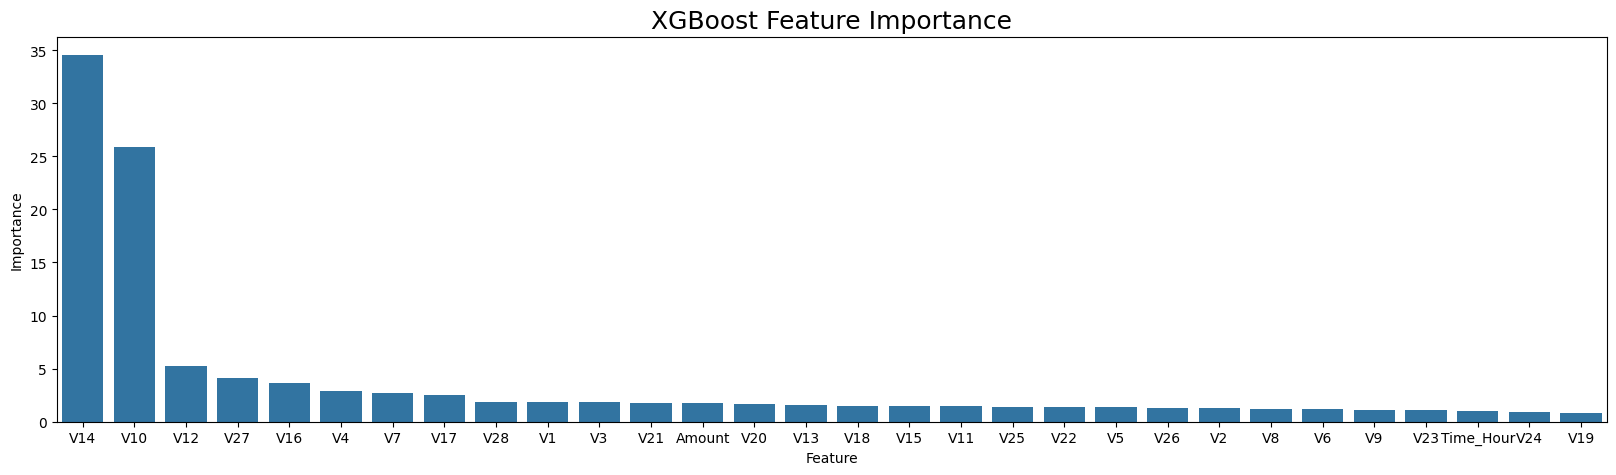

In [ ]:
plt.figure(figsize=(20,5))
sns.barplot(x='Feature', y='Importance', data = importance_df)
plt.title("XGBoost Feature Importance", fontsize = 18)
plt.show()

100%|===================| 56844/56961 [01:53<00:00]        

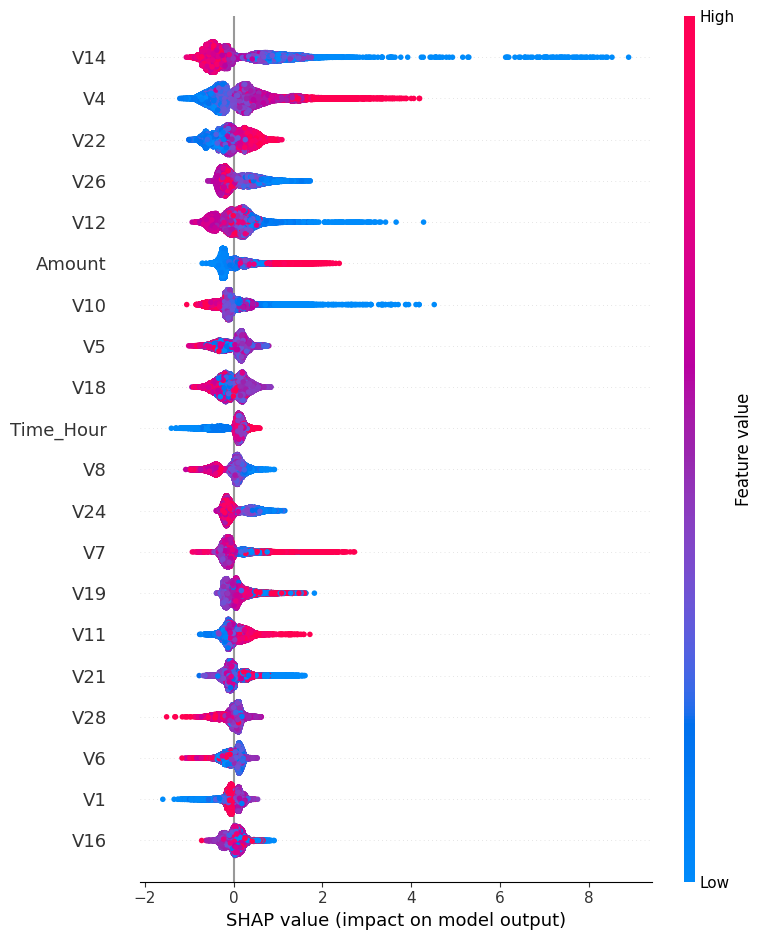

In [ ]:
import shap

explainer = shap.Explainer(XGBmodel, X_test_SKF_cv)
shap_values = explainer(X_test_SKF_cv)

shap.summary_plot(shap_values, X_test_SKF_cv)

In [ ]:
from sklearn.inspection import permutation_importance
result = permutation_importance(XGBmodel, X_test_SKF_cv, y_test_SKF_cv, scoring = 'roc_auc')
feature_importance = pd.DataFrame({'Feature': X_test_SKF_cv.columns, 'Importance': result.importances_mean}).sort_values(by = 'Importance', ascending = False)
feature_importance

,Feature,Importance
3,V4,0.022013
13,V14,0.009260
25,V26,0.003924
9,V10,0.003759
10,V11,0.003513
21,V22,0.003171
28,Amount,0.003028
7,V8,0.002318
11,V12,0.001999
20,V21,0.001875


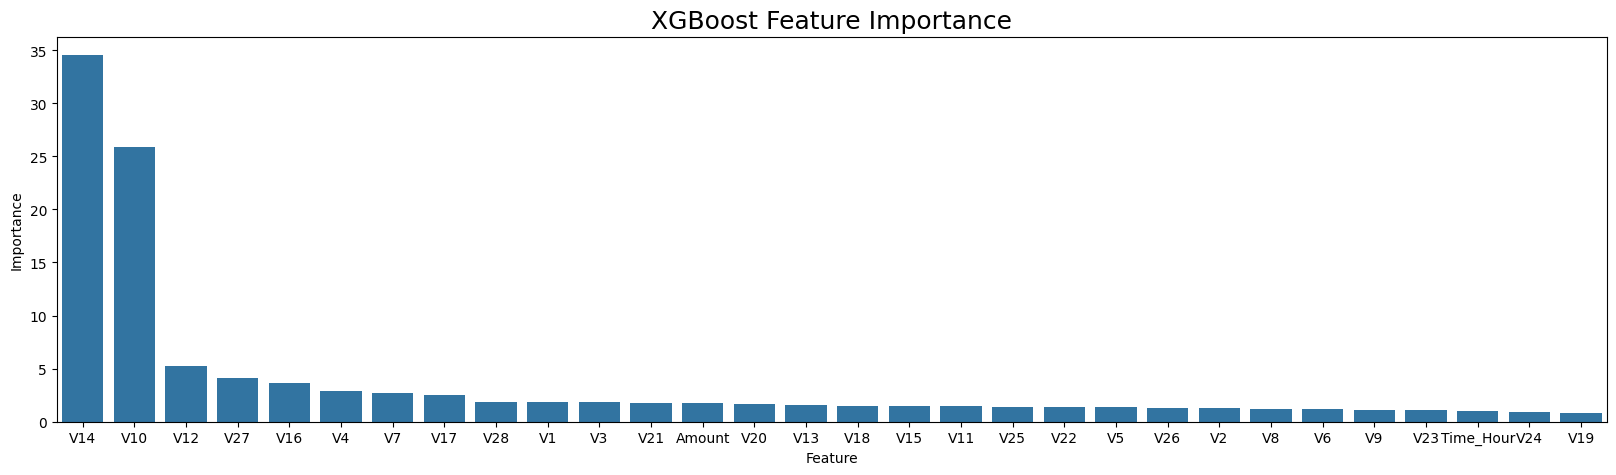

In [ ]:
plt.figure(figsize=(20,5))
sns.barplot(x='Feature', y='Importance', data = importance_df)
plt.title("XGBoost Feature Importance", fontsize = 18)
plt.show()

**Model Building with Balancing Classes**

**Oversampling with RandomOverSampler with SKF**

In [ ]:
from imblearn.over_sampling import RandomOverSampler

skf = StratifiedKFold(n_splits = 5, random_state = None)

for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
  X_train = X.loc[train_index]
  y_train = y.loc[train_index]
  X_test = X.loc[test_index]
  y_test = y.loc[test_index]

  ROS = RandomOverSampler(sampling_strategy = 0.5)
  X_over, y_over = ROS.fit_resample(X_train, y_train)

X_over = pd.DataFrame(X_over, columns = cols)

In [ ]:
X_over

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Time_Hour
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341173,-4.198735,0.194121,-3.917586,3.920748,-1.875486,-2.118933,-3.614445,1.687884,-2.189871,-4.684233,...,0.801312,-0.183001,-0.440387,0.292539,-0.144967,-0.251744,1.249414,-0.131525,238.90,20
341174,-2.923827,1.524837,-3.018758,3.289291,-5.755542,2.218276,-0.509995,-3.569444,-1.016592,-4.320536,...,-0.511657,-0.122724,-4.288639,0.563797,-0.949451,-0.204532,1.510206,-0.324706,1354.25,18
341175,0.316459,3.809076,-5.615159,6.047445,1.554026,-2.651353,-0.746579,0.055586,-2.678679,-4.959493,...,0.208828,-0.511747,-0.583813,-0.219845,1.474753,0.491192,0.518868,0.402528,1.00,2
341176,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,0


Logistic Regression Model with ROS
Max auc_roc for l1:  0.5
Max auc_roc for l2:  0.5095839192451482
Parameters for l1 regularizations
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
[0.]
{np.int64(1): array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0

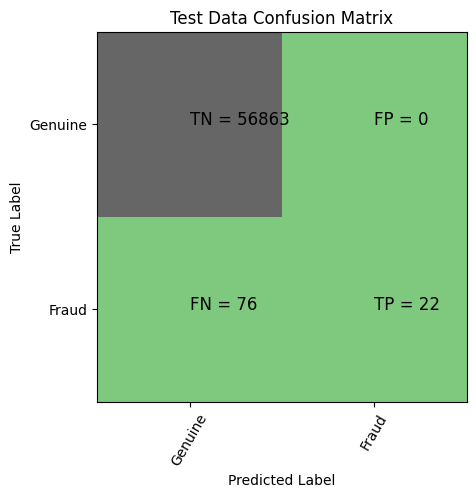

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       1.00      0.22      0.37        98

    accuracy                           1.00     56961
   macro avg       1.00      0.61      0.68     56961
weighted avg       1.00      1.00      1.00     56961

Accuracy of Logistic model with l1 regularization: 0.9982795245869981
Confusion Matrix


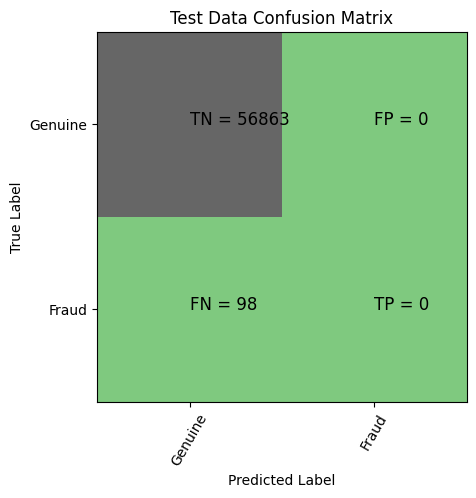

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961

l2 roc_value: 0.6431516207770412
l2 threshold: 0.49997511372702197
ROC for the test dataset 64.3%


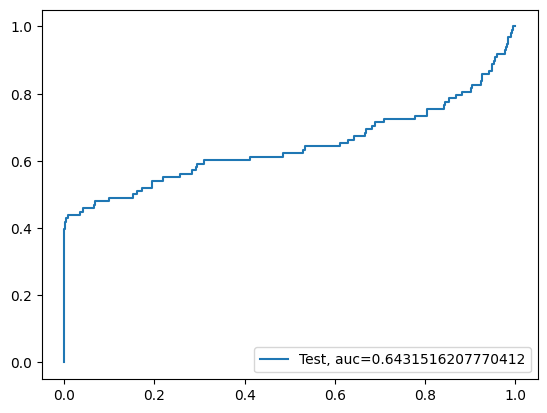

l1 roc_value: 0.5
l1 threshold inf
ROC for the test dataset 50.0%


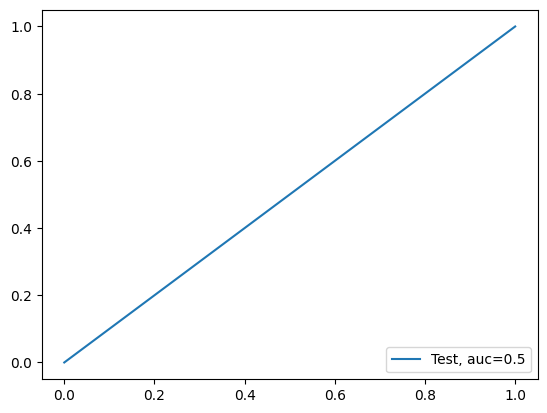

Time Taken by Model--- 102.69525408744812 seconds ---
------------------------------------------------------------


In [ ]:
#Run Logistic Regression Model with L1 and L2 Regularization

print("Logistic Regression Model with ROS")
start_time = time.time()
df_Results = buildAndRunLogisticModels(df_Results, "Data Imbalance Handling with ROS", X_over, y_over, X_test, y_test)
print("Time Taken by Model--- %s seconds ---" % (time.time() - start_time))
print('-'*60)

KNN with ROS
Model Score
0.9980688541282632
Confusion Matrix


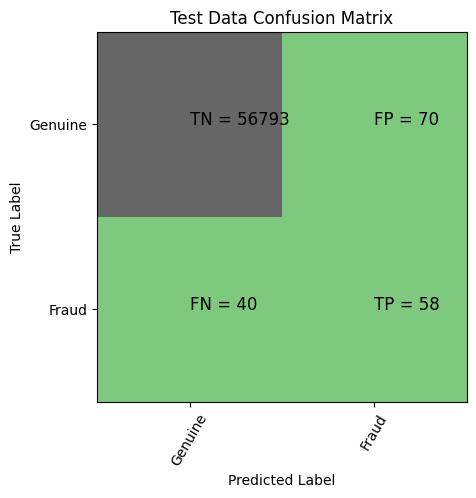

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.45      0.59      0.51        98

    accuracy                           1.00     56961
   macro avg       0.73      0.80      0.76     56961
weighted avg       1.00      1.00      1.00     56961

KNN roc value: 0.805604465728046
KNN threshold: 0.2
ROC for the test dataset 80.6%


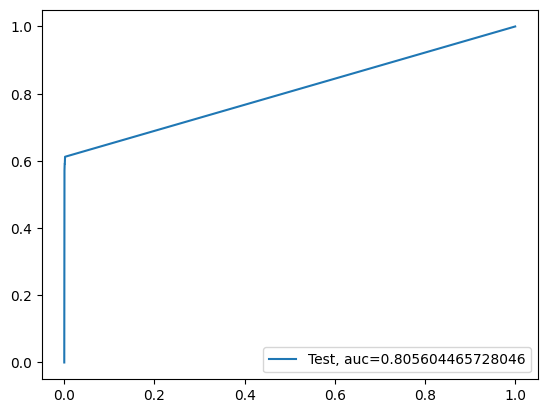

Time Taken by Model--- 251.12043070793152 seconds ---
------------------------------------------------------------


In [ ]:
#Run KNN Model

print("KNN with ROS")
start_time = time.time()
df_Results = buildAndRunKNNModels(df_Results, "Data Imbalance Handling with ROS", X_over, y_over, X_test, y_test)
print("Time Taken by Model--- %s seconds ---" % (time.time() - start_time))
print('-'*60)

Decision Tree Model with ROS
giniscore: 0.9990168711925703
Confusion Matrix


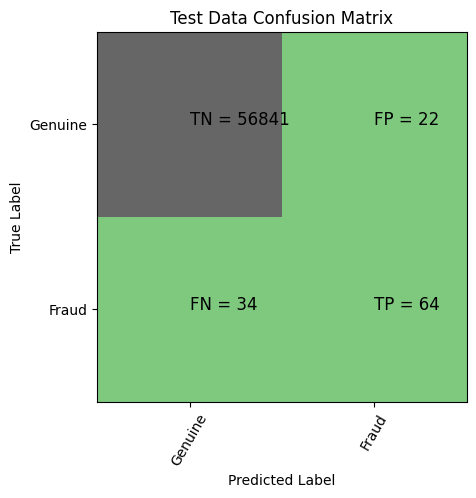

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.74      0.65      0.70        98

    accuracy                           1.00     56961
   macro avg       0.87      0.83      0.85     56961
weighted avg       1.00      1.00      1.00     56961

ginitree_roc_value: 0.8263371648362139
Tree threshold: 1.0
ROC for the test dataset 82.6%


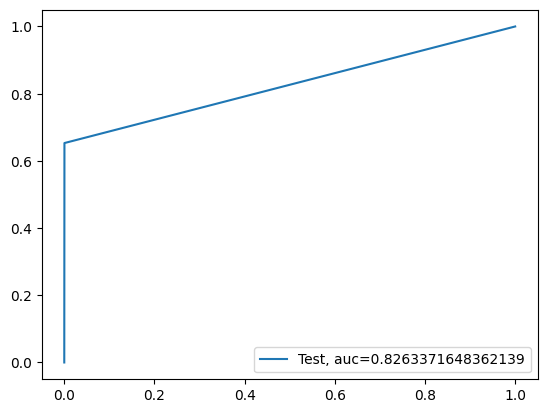

entropyscore: 0.9990344270641316
Confusion Matrix


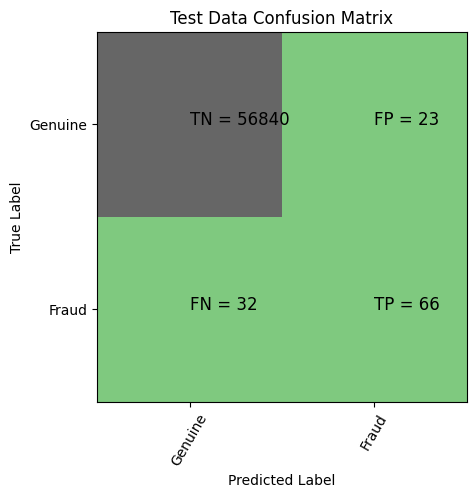

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.74      0.67      0.71        98

    accuracy                           1.00     56961
   macro avg       0.87      0.84      0.85     56961
weighted avg       1.00      1.00      1.00     56961

entropytree_roc_value: 0.836532453404836
Tree threshold: 1.0
ROC for the test dataset 83.7%


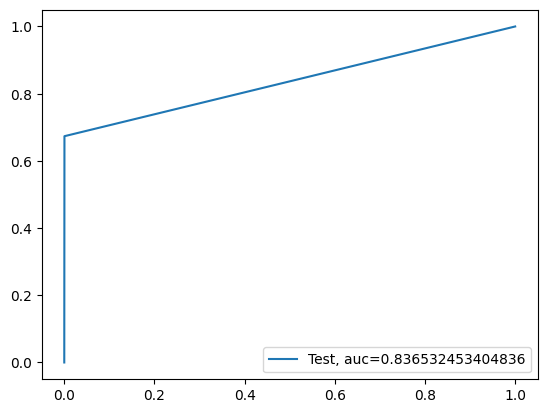

Time Taken by Model--- 33.265581130981445 seconds ---
------------------------------------------------------------


In [ ]:
#Run Decision Tree Model
print("Decision Tree Model with ROS")
start_time = time.time()
df_Results = buildAndRunDecisionTreeModels(df_Results, "Data Imbalance Handling with ROS", X_over, y_over, X_test, y_test)
print("Time Taken by Model--- %s seconds ---" % (time.time() - start_time))
print('-'*60)

Random Forest Model with ROS
MOdel Accuracy: 0.9995084355962852
Confusion Matrix


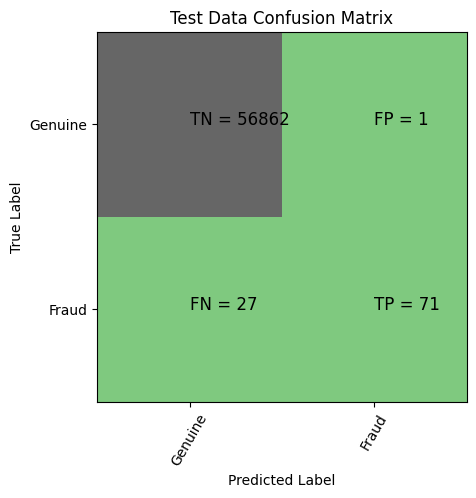

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.99      0.72      0.84        98

    accuracy                           1.00     56961
   macro avg       0.99      0.86      0.92     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest roc_value: 0.9454853358609505
Random Forest threshold: 0.02
ROC for the test dataset 94.5%


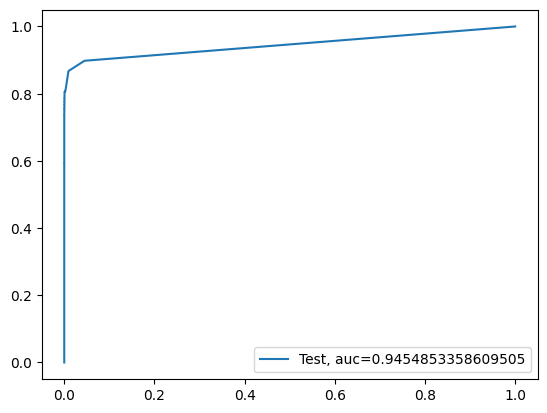

Time Taken by Model--- 238.51112580299377 seconds ---
------------------------------------------------------------


In [ ]:
#Run Random Forest Model
print("Random Forest Model with ROS")
start_time = time.time()
df_Results = buildAndRunRandomForestModels(df_Results, "Data Imbalance Handling with ROS", X_over, y_over, X_test, y_test)
print("Time Taken by Model--- %s seconds ---" % (time.time() - start_time))
print('-'*60)

XGBoost Model with ROS
Model Accuracy: 0.9994733238531627
Confusion Matrix


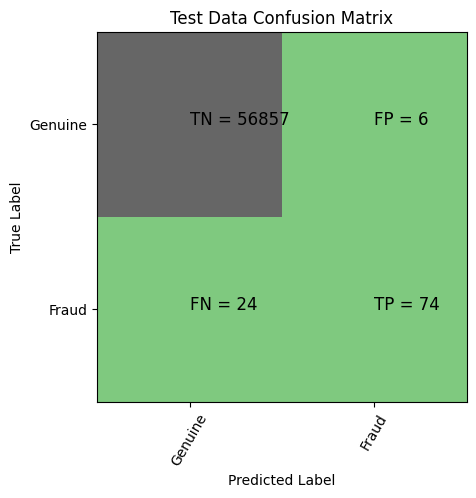

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.93      0.76      0.83        98

    accuracy                           1.00     56961
   macro avg       0.96      0.88      0.92     56961
weighted avg       1.00      1.00      1.00     56961

XGboost roc_value: 0.9852619274324576
XGboost threshold: 2.385580046393443e-05
ROC for the test dataset 98.5%


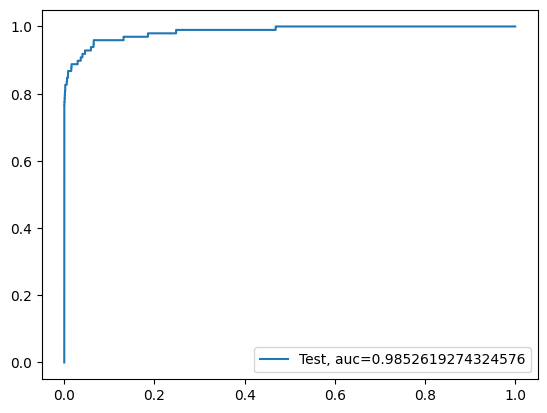

Time Taken by Model--- 6.22322416305542 seconds ---
------------------------------------------------------------


In [ ]:
#Run XGBoost Model
print("XGBoost Model with ROS")
start_time = time.time()
df_Results = buildAndRunXGBoostModels(df_Results, "Data Imbalance Handling with ROS", X_over, y_over, X_test, y_test)
print("Time Taken by Model--- %s seconds ---" % (time.time() - start_time))
print('-'*60)

In [ ]:
df_Results

,Methodology,Model,Accuracy,roc_value,threshold
0,RepeatedKFold Cross Validation,Logistic Regression with L2 Regularization,0.998209,0.530331,0.499277
1,RepeatedKFold Cross Validation,Logistic Regression with L1 Regularization,0.998876,0.847137,0.044844
2,RepeatedKFold Cross Validation,KNN,0.999175,0.842961,0.200000
3,RepeatedKFold Cross Validation,Tree Model with gini criteria,0.999122,0.872338,1.000000
4,RepeatedKFold Cross Validation,Tree Model with entropy criteria,0.999280,0.872417,1.000000
5,RepeatedKFold Cross Validation,Random Forest,0.999456,0.954092,0.010000
6,RepeatedKFold Cross Validation,SVMmodel,0.998227,0.495462,0.001686
7,RepeatedKFold Cross Validation,XGBoost,0.999526,0.971969,0.000035
8,StratifiedKFold Cross Validation,Logistic Regression with L2 Regularization,0.998280,0.611162,0.499392
9,StratifiedKFold Cross Validation,Logistic Regression with L1 Regularization,0.998754,0.889076,0.021087


**Oversampling with SMOTE**

In [ ]:
from imblearn import over_sampling

skf = StratifiedKFold(n_splits = 5, random_state = None)

for fold, (train_index, test_index) in enumerate(skf.split(X,y), 1):
    X_train = X.loc[train_index]
    y_train = y.loc[train_index]
    X_test = X.loc[test_index]
    y_test = y.loc[test_index]

    SMOTE = over_sampling.SMOTE(random_state = 0)
    X_train_smote, y_train_smote = SMOTE.fit_resample(X_train, y_train)

X_train_smote = pd.DataFrame(data = X_train_smote, columns = cols)

In [ ]:
X_train_smote

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Time_Hour
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.620000,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.690000,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.660000,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.500000,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.990000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454899,-4.327350,0.656053,-5.198853,6.785082,4.780046,-3.970449,-2.408721,-0.243143,-3.893562,-4.093031,...,-0.054021,0.102642,-0.092014,-0.372908,0.816546,0.640573,0.541405,0.739330,1.000000,11
454900,0.533711,2.425788,-5.558186,4.316875,-2.222487,-2.044563,-4.484247,1.192081,-0.646287,-5.152914,...,0.704439,0.130667,0.645444,-0.022450,-1.888011,0.340113,0.700767,0.151825,1.000000,2
454901,-4.695787,3.505453,-4.215212,4.302026,-2.563278,-1.216792,-4.204375,-0.038850,-2.661532,-3.616622,...,2.014641,-0.527933,-0.303529,0.128994,0.005046,-0.281177,-1.461828,-1.037526,45.613365,14
454902,-9.889809,7.383093,-12.931883,4.274998,-7.639267,-3.429042,-8.368289,6.889117,-2.385963,-6.061497,...,0.931971,-0.877886,-0.196066,-0.035109,0.541774,-0.263884,1.132927,0.225392,99.990000,14


Logistic Regression Model with SMOTE
Max auc_roc for l1:  0.5
Max auc_roc for l2:  0.5
Parameters for l1 regularizations
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
[0.]
{np.int64(1): array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,

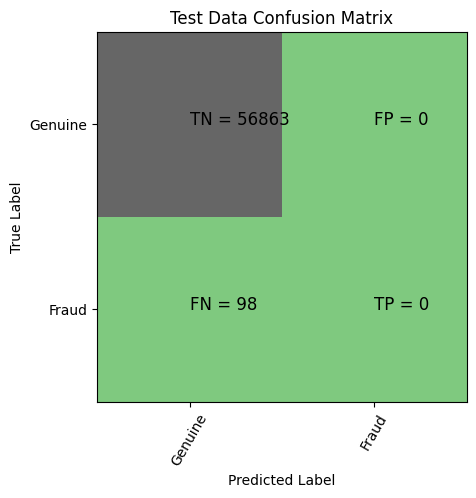

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961

Accuracy of Logistic model with l1 regularization: 0.9982795245869981
Confusion Matrix


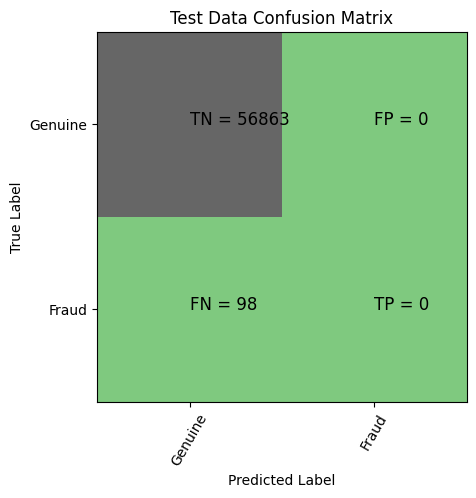

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961

l2 roc_value: 0.5
l2 threshold: inf
ROC for the test dataset 50.0%


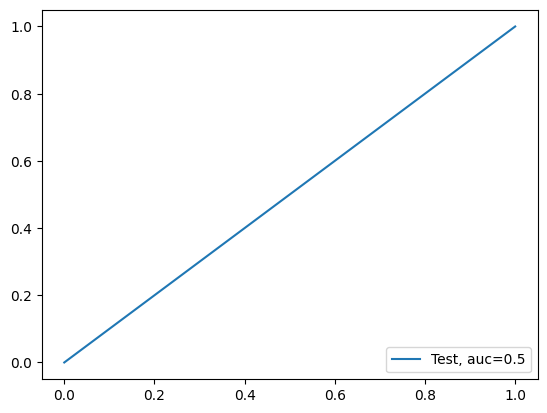

l1 roc_value: 0.5
l1 threshold inf
ROC for the test dataset 50.0%


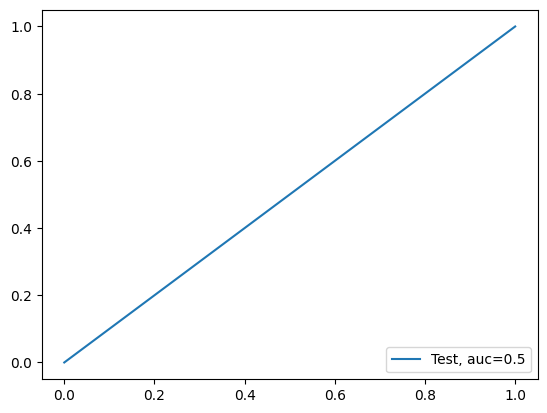

Time Taken by Model--- 118.50541615486145 seconds ---
------------------------------------------------------------


In [ ]:
#Run Logistic Regression Model with L1 and L2 Regularization
print("Logistic Regression Model with SMOTE")
start_time = time.time()
df_Results = buildAndRunLogisticModels(df_Results, "Data Imbalance Handling with SMOTE", X_train_smote, y_train_smote, X_test, y_test)
print("Time Taken by Model--- %s seconds ---" % (time.time() - start_time))
print('-'*60)

KNN Model with SMOTE
Model Score
0.9946805709169432
Confusion Matrix


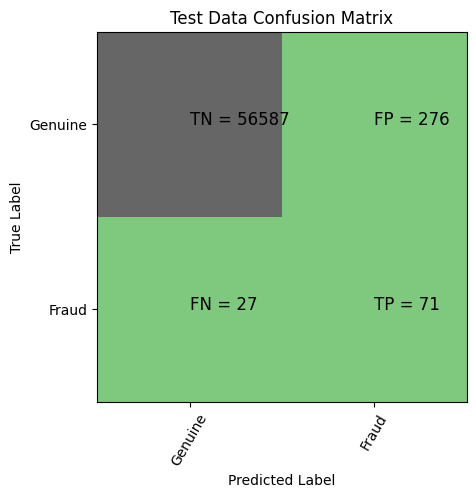

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.20      0.72      0.32        98

    accuracy                           0.99     56961
   macro avg       0.60      0.86      0.66     56961
weighted avg       1.00      0.99      1.00     56961

KNN roc value: 0.8602674455287628
KNN threshold: 0.6
ROC for the test dataset 86.0%


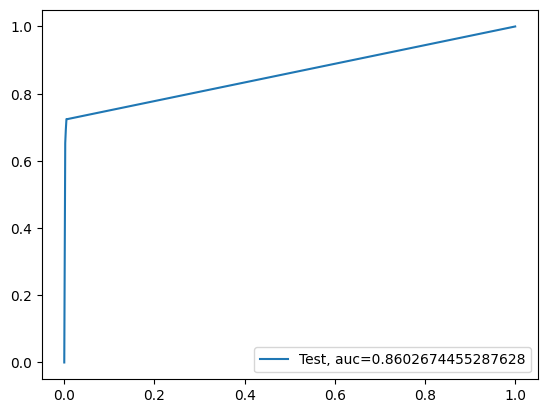

Time Taken by Model--- 305.92333126068115 seconds ---
------------------------------------------------------------


In [ ]:
#Run KNN Model
print("KNN Model with SMOTE")
start_time = time.time()
df_Results = buildAndRunKNNModels(df_Results, "Data Imbalance Handling with SMOTE", X_train_smote, y_train_smote, X_test, y_test)
print("Time Taken by Model--- %s seconds ---" % (time.time() - start_time))
print('-'*60)

Decision Tree Model with SMOTE
giniscore: 0.9977001808254771
Confusion Matrix


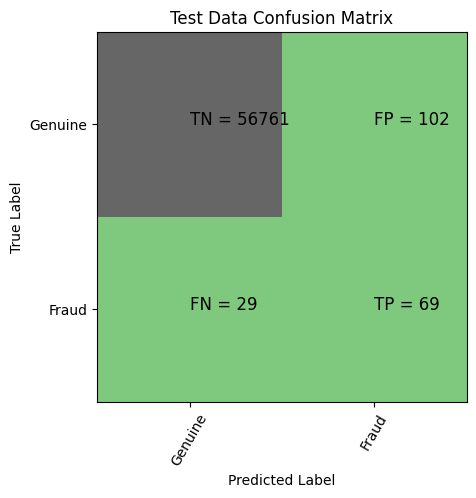

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.40      0.70      0.51        98

    accuracy                           1.00     56961
   macro avg       0.70      0.85      0.76     56961
weighted avg       1.00      1.00      1.00     56961

ginitree_roc_value: 0.8511439237953592
Tree threshold: 1.0
ROC for the test dataset 85.1%


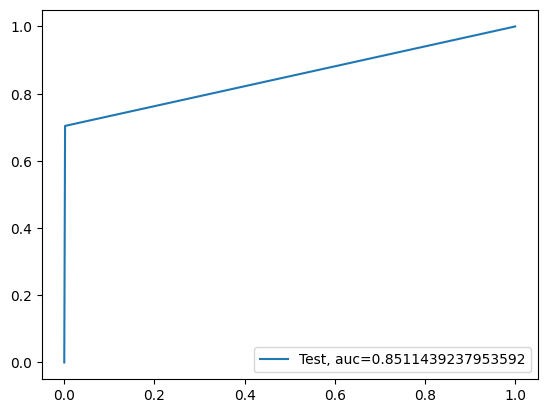

entropyscore: 0.9969803900914661
Confusion Matrix


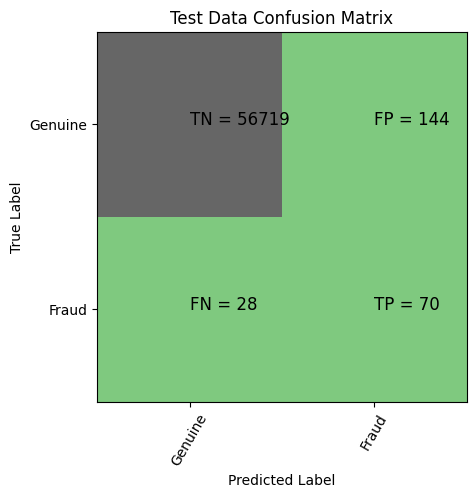

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.33      0.71      0.45        98

    accuracy                           1.00     56961
   macro avg       0.66      0.86      0.72     56961
weighted avg       1.00      1.00      1.00     56961

entropytree_roc_value: 0.8558766559223799
Tree threshold: 1.0
ROC for the test dataset 85.6%


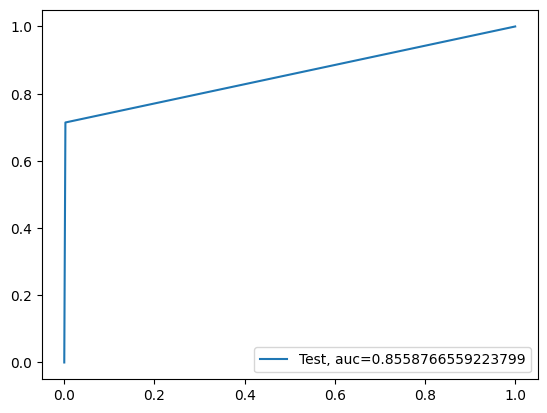

Time Taken by Model--- 120.79093790054321 seconds ---
------------------------------------------------------------


In [ ]:
#Run Decision Tree Model
print("Decision Tree Model with SMOTE")
start_time = time.time()
df_Results = buildAndRunDecisionTreeModels(df_Results, "Data Imbalance Handling with SMOTE", X_train_smote, y_train_smote, X_test, y_test)
print("Time Taken by Model--- %s seconds ---" % (time.time() - start_time))
print('-'*60)

Random Forest Model with SMOTE
MOdel Accuracy: 0.999490879724724
Confusion Matrix


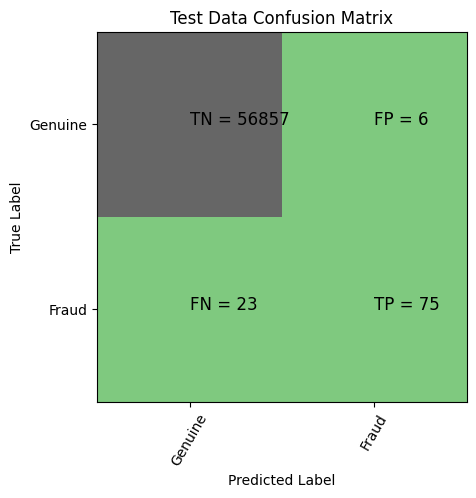

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.93      0.77      0.84        98

    accuracy                           1.00     56961
   macro avg       0.96      0.88      0.92     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest roc_value: 0.9653649283078161
Random Forest threshold: 0.05
ROC for the test dataset 96.5%


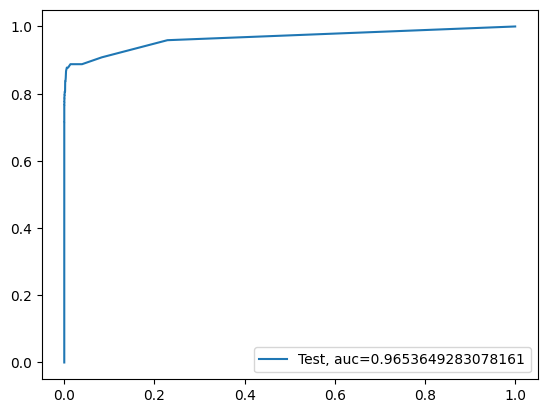

Time Taken by Model--- 618.7156271934509 seconds ---
------------------------------------------------------------


In [ ]:
#Run Random Forest Model
print("Random Forest Model with SMOTE")
start_time = time.time()
df_Results = buildAndRunRandomForestModels(df_Results, "Data Imbalance Handling with SMOTE", X_train_smote, y_train_smote, X_test, y_test)
print("Time Taken by Model--- %s seconds ---" % (time.time() - start_time))
print('-'*60)

XGBoost Model with SMOTE
Model Accuracy: 0.9994031003669177
Confusion Matrix


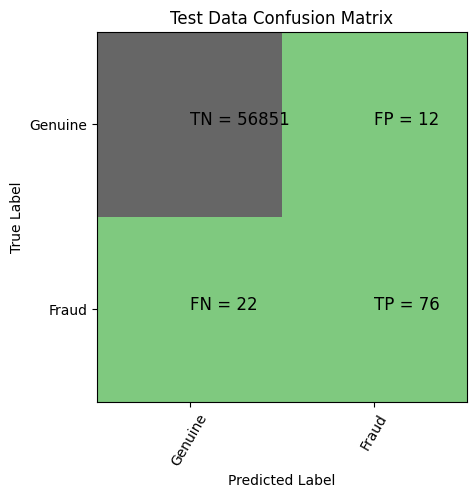

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.86      0.78      0.82        98

    accuracy                           1.00     56961
   macro avg       0.93      0.89      0.91     56961
weighted avg       1.00      1.00      1.00     56961

XGboost roc_value: 0.9704734293344512
XGboost threshold: 0.000144163059303537
ROC for the test dataset 97.0%


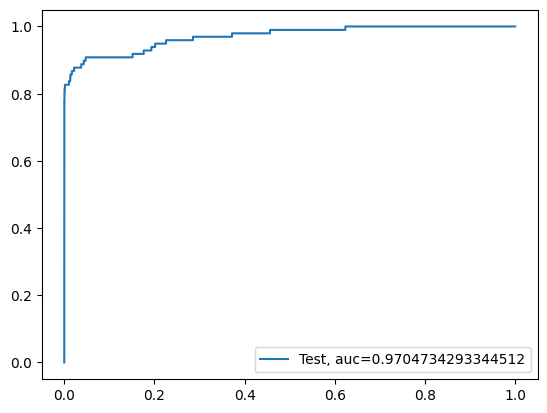

Time Taken by Model--- 10.202946424484253 seconds ---
------------------------------------------------------------


In [ ]:
#Run XGBoost Model
print("XGBoost Model with SMOTE")
start_time = time.time()
df_Results = buildAndRunXGBoostModels(df_Results, "Data Imbalance Handling with SMOTE", X_train_smote, y_train_smote, X_test, y_test)
print("Time Taken by Model--- %s seconds ---" % (time.time() - start_time))
print('-'*60)

In [ ]:
#Run SVM Model
#print("SVM Model with SMOTE")
#start_time = time.time()
#df_Results = buildAndRunSVMModels(df_Results, "Data Imbalance Handling with SMOTE", X_train_smote, y_train_smote, X_test, y_test)
#print("Time Taken by Model--- %s seconds ---" % (time.time() - start_time))
#print('-'*60)

In [ ]:
df_Results

,Methodology,Model,Accuracy,roc_value,threshold
0,RepeatedKFold Cross Validation,Logistic Regression with L2 Regularization,0.998209,0.530331,0.499277
1,RepeatedKFold Cross Validation,Logistic Regression with L1 Regularization,0.998876,0.847137,0.044844
2,RepeatedKFold Cross Validation,KNN,0.999175,0.842961,0.200000
3,RepeatedKFold Cross Validation,Tree Model with gini criteria,0.999122,0.872338,1.000000
4,RepeatedKFold Cross Validation,Tree Model with entropy criteria,0.999280,0.872417,1.000000
5,RepeatedKFold Cross Validation,Random Forest,0.999456,0.954092,0.010000
6,RepeatedKFold Cross Validation,SVMmodel,0.998227,0.495462,0.001686
7,RepeatedKFold Cross Validation,XGBoost,0.999526,0.971969,0.000035
8,StratifiedKFold Cross Validation,Logistic Regression with L2 Regularization,0.998280,0.611162,0.499392
9,StratifiedKFold Cross Validation,Logistic Regression with L1 Regularization,0.998754,0.889076,0.021087


**Oversampling with ADASYN**

In [ ]:
skf = StratifiedKFold(n_splits = 5, random_state = None)

for fold, (train_index, test_index) in enumerate(skf.split(X,y), 1):
    X_train = X.loc[train_index]
    y_train = y.loc[train_index]
    X_test = X.loc[test_index]
    y_test = y.loc[test_index]

    ADASYN = over_sampling.ADASYN(random_state = 0)
    X_train_adasyn, y_train_adasyn = ADASYN.fit_resample(X_train, y_train)

X_train_adasyn = pd.DataFrame(data = X_train_adasyn, columns = cols)

In [ ]:
X_train_adasyn

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Time_Hour
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.620000,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.690000,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.660000,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.500000,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.990000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454903,0.385553,1.285312,-4.969093,2.239693,-0.763704,-0.158214,-3.481553,0.986913,-0.778991,-5.087504,...,0.692702,-0.006720,0.081551,-0.564377,0.121458,-0.179175,0.736945,0.290516,39.752447,14
454904,-0.540022,1.316251,-2.645360,0.230157,-0.657379,-0.831097,-1.998662,0.441598,-1.775231,-3.489112,...,0.071555,-0.623051,-0.022586,0.201334,-0.219504,0.371812,0.349289,0.268261,39.909961,10
454905,-1.649978,1.524326,-1.707824,0.793960,-0.315142,1.072856,-3.462485,-2.492562,1.080544,-4.240807,...,-0.036157,0.872140,-0.264391,-0.387581,0.192843,-0.085556,0.406897,0.097094,38.816930,2
454906,-3.682566,2.973493,-3.355470,3.232379,-1.765320,-1.064729,-3.335506,-0.803219,-1.801274,-3.552889,...,1.872837,-0.845613,-0.269765,0.052057,0.023284,-0.447568,-1.203049,-0.805061,44.773914,15


Logistic Regression Model with ADASYN
Max auc_roc for l1:  0.5
Max auc_roc for l2:  0.6091741619819793
Parameters for l1 regularizations
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
[0.]
{np.int64(1): array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
        0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5

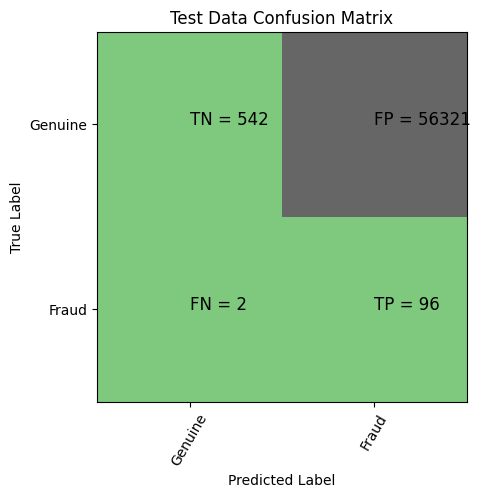

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.01      0.02     56863
           1       0.00      0.98      0.00        98

    accuracy                           0.01     56961
   macro avg       0.50      0.49      0.01     56961
weighted avg       0.99      0.01      0.02     56961

Accuracy of Logistic model with l1 regularization: 0.9982795245869981
Confusion Matrix


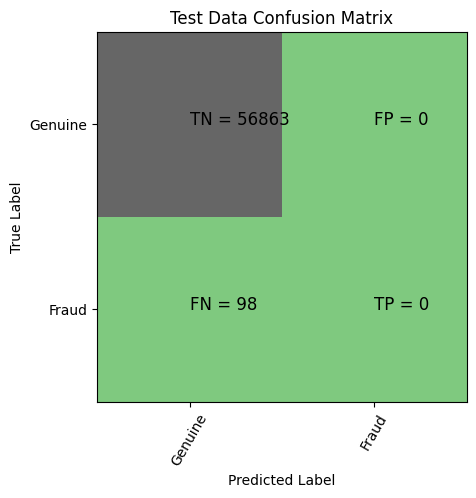

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961

l2 roc_value: 0.4511041037768184
l2 threshold: 0.5762819111863179
ROC for the test dataset 45.1%


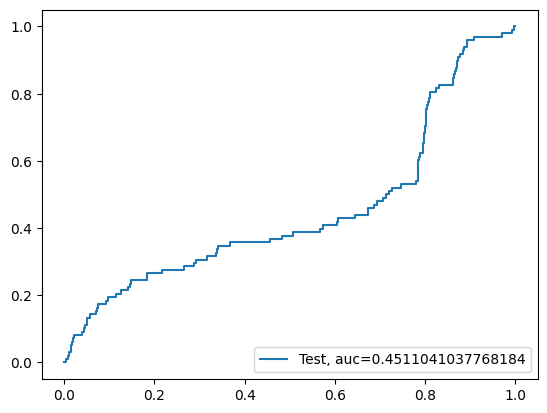

l1 roc_value: 0.5
l1 threshold inf
ROC for the test dataset 50.0%


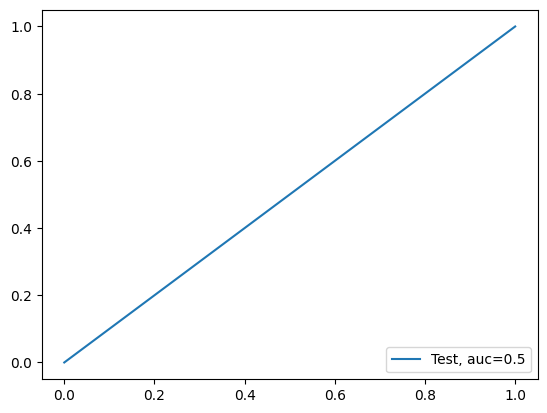

Time Taken by Model--- 144.1533226966858 seconds ---
------------------------------------------------------------


In [ ]:
#Run Logistic Regression Model with L1 and L2 Regularization
print("Logistic Regression Model with ADASYN")
start_time = time.time()
df_Results = buildAndRunLogisticModels(df_Results, "Data Imbalance Handling with ADASYN", X_train_adasyn, y_train_adasyn, X_test, y_test)
print("Time Taken by Model--- %s seconds ---" % (time.time() - start_time))
print('-'*60)

KNN Model with ADASYN
Model Score
0.9945050122013307
Confusion Matrix


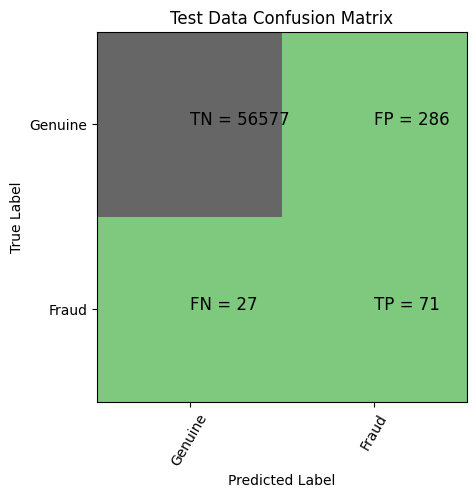

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56863
           1       0.20      0.72      0.31        98

    accuracy                           0.99     56961
   macro avg       0.60      0.86      0.65     56961
weighted avg       1.00      0.99      1.00     56961

KNN roc value: 0.8601937811862167
KNN threshold: 0.6
ROC for the test dataset 86.0%


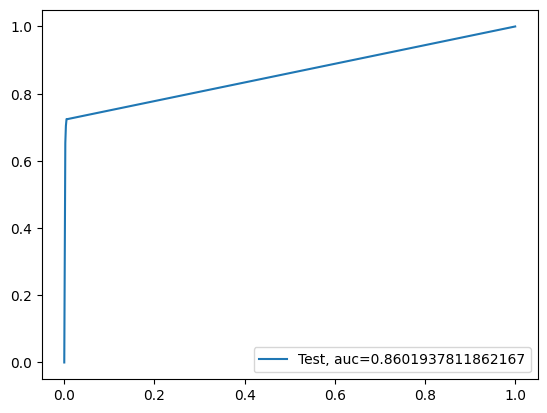

Time Taken by Model--- 284.27029609680176 seconds ---
------------------------------------------------------------


In [ ]:
#Run KNN Model
print("KNN Model with ADASYN")
start_time = time.time()
df_Results = buildAndRunKNNModels(df_Results, "Data Imbalance Handling with ADASYN", X_train_adasyn, y_train_adasyn, X_test, y_test)
print("Time Taken by Model--- %s seconds ---" % (time.time() - start_time))
print('-'*60)

Decision Tree Model with ADASYN
giniscore: 0.9979459630273345
Confusion Matrix


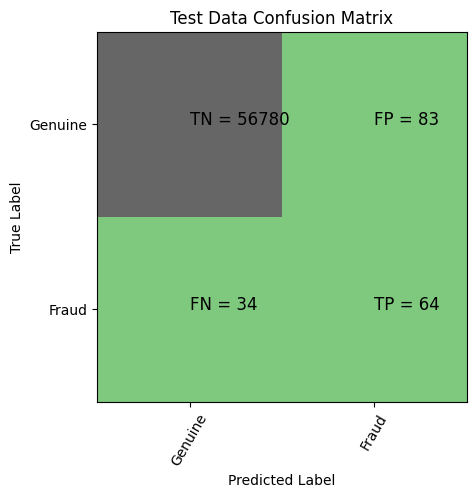

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.44      0.65      0.52        98

    accuracy                           1.00     56961
   macro avg       0.72      0.83      0.76     56961
weighted avg       1.00      1.00      1.00     56961

ginitree_roc_value: 0.8258007879303172
Tree threshold: 1.0
ROC for the test dataset 82.6%


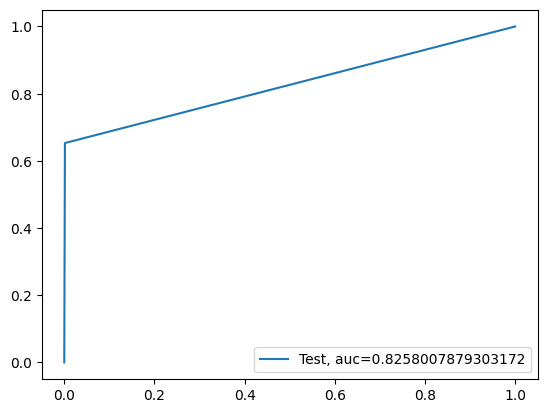

entropyscore: 0.9954179175225154
Confusion Matrix


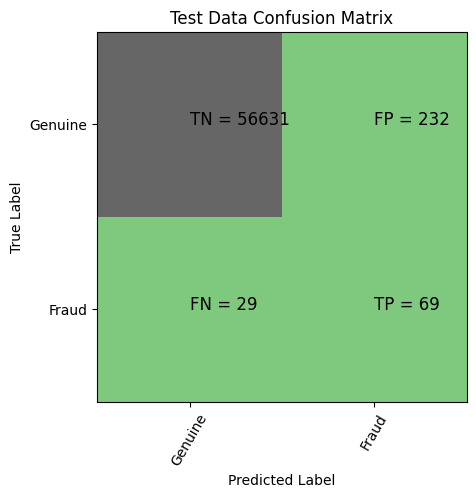

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.23      0.70      0.35        98

    accuracy                           1.00     56961
   macro avg       0.61      0.85      0.67     56961
weighted avg       1.00      1.00      1.00     56961

entropytree_roc_value: 0.8500008254713172
Tree threshold: 1.0
ROC for the test dataset 85.0%


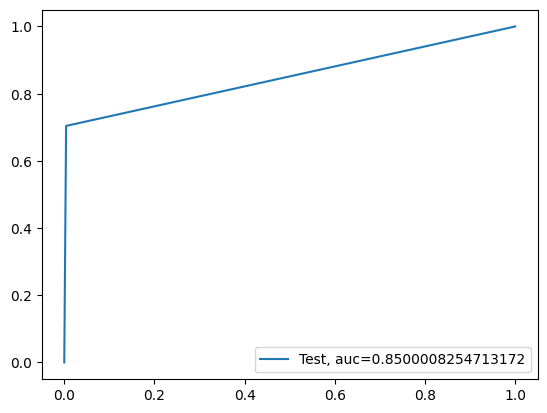

Time Taken by Model--- 91.26016068458557 seconds ---
------------------------------------------------------------


In [ ]:
#Run Decision Tree Model
print("Decision Tree Model with ADASYN")
start_time = time.time()
df_Results = buildAndRunDecisionTreeModels(df_Results, "Data Imbalance Handling with ADASYN", X_train_adasyn, y_train_adasyn, X_test, y_test)
print("Time Taken by Model--- %s seconds ---" % (time.time() - start_time))
print('-'*60)

Random Forest Model with ADASYN
MOdel Accuracy: 0.9995259914678464
Confusion Matrix


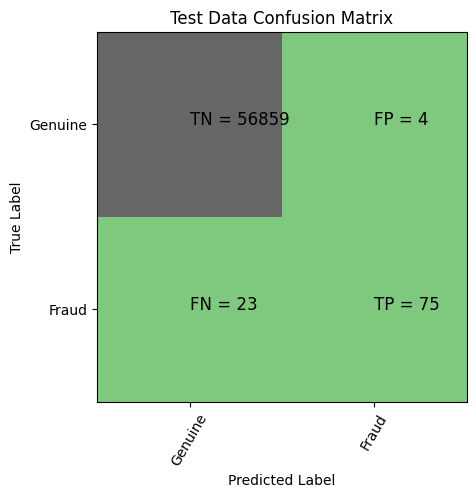

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.95      0.77      0.85        98

    accuracy                           1.00     56961
   macro avg       0.97      0.88      0.92     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest roc_value: 0.9632721790684162
Random Forest threshold: 0.03
ROC for the test dataset 96.3%


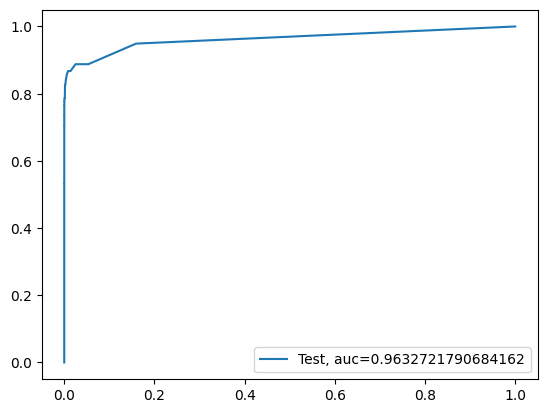

Time Taken by Model--- 484.9634094238281 seconds ---
------------------------------------------------------------


In [ ]:
#Run Random Forest Model
print("Random Forest Model with ADASYN")
start_time = time.time()
df_Results = buildAndRunRandomForestModels(df_Results, "Data Imbalance Handling with ADASYN", X_train_adasyn, y_train_adasyn, X_test, y_test)
print("Time Taken by Model--- %s seconds ---" % (time.time() - start_time))
print('-'*60)

XGBoost Model with ADASYN
Model Accuracy: 0.999350432752234
Confusion Matrix


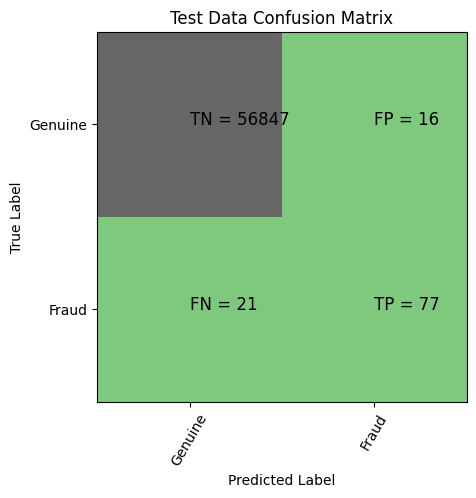

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.83      0.79      0.81        98

    accuracy                           1.00     56961
   macro avg       0.91      0.89      0.90     56961
weighted avg       1.00      1.00      1.00     56961

XGboost roc_value: 0.9696561230052754
XGboost threshold: 0.00012316476204432547
ROC for the test dataset 97.0%


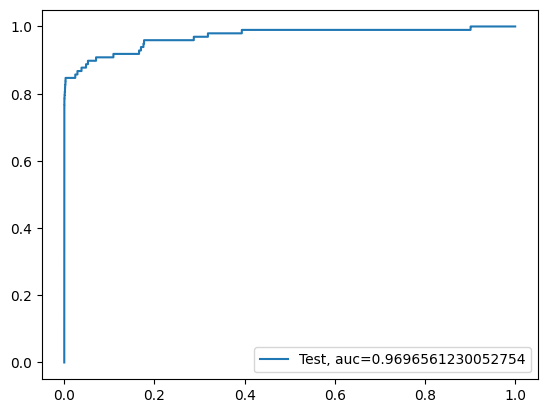

Time Taken by Model--- 6.684271812438965 seconds ---
------------------------------------------------------------


In [ ]:
#Run XGBoost Model
print("XGBoost Model with ADASYN")
start_time = time.time()
df_Results = buildAndRunXGBoostModels(df_Results, "Data Imbalance Handling with ADASYN", X_train_adasyn, y_train_adasyn, X_test, y_test)
print("Time Taken by Model--- %s seconds ---" % (time.time() - start_time))
print('-'*60)

In [ ]:
df_Results

,Methodology,Model,Accuracy,roc_value,threshold
0,RepeatedKFold Cross Validation,Logistic Regression with L2 Regularization,0.998209,0.530331,0.499277
1,RepeatedKFold Cross Validation,Logistic Regression with L1 Regularization,0.998876,0.847137,0.044844
2,RepeatedKFold Cross Validation,KNN,0.999175,0.842961,0.200000
3,RepeatedKFold Cross Validation,Tree Model with gini criteria,0.999122,0.872338,1.000000
4,RepeatedKFold Cross Validation,Tree Model with entropy criteria,0.999280,0.872417,1.000000
5,RepeatedKFold Cross Validation,Random Forest,0.999456,0.954092,0.010000
6,RepeatedKFold Cross Validation,SVMmodel,0.998227,0.495462,0.001686
7,RepeatedKFold Cross Validation,XGBoost,0.999526,0.971969,0.000035
8,StratifiedKFold Cross Validation,Logistic Regression with L2 Regularization,0.998280,0.611162,0.499392
9,StratifiedKFold Cross Validation,Logistic Regression with L1 Regularization,0.998754,0.889076,0.021087


<h3>Conclusion:</h3>
<b>XGBoost model</b> with Random Oversampling with StratifiedKFold CV <b>works best</b> of all other models under various types of oversampling techniques.

<h3>Hyperparameter Tuning</h3>
Hyperparameter Tuning of XGBoost Regression

In [ ]:
param_test = {
    'max_depth': range(3,10,2),
    'min_child_weight': range(1,6,2),
    'n_estimators': range(60,130,150),
    'learning_rate': [0.05, 0.1, 0.125, 0.15, 0.2],
    'gamma': [i/10.0 for i in range(0,5)],
    'subsample': [i/10.0 for i in range(7,10)],
    'colsample_bytree': [i/10.0 for i in range(7,10)]
}

gsearch1 = RandomizedSearchCV(estimator = XGBClassifier(base_score = 0.5,
                                                        booster = 'gbtree',
                                                        colsample_bylevel = 1,
                                                        colsample_bynode = 1,
                                                        max_delta_step = 0,
                                                        missing = None,
                                                        n_jobs = -1,
                                                        nthread = None,
                                                        objective = 'binary:logistic',
                                                        random_state = 42,
                                                        reg_alpha = 0,
                                                        reg_lembda = 1,
                                                        scale_pos_weight = 1,
                                                        seed = None,
                                                        silent = None,
                                                        verbosity = 1),
                              param_distributions = param_test,
                              n_iter = 5,
                              scoring = 'roc_auc',
                              n_jobs = -1,
                              cv = 5)
gsearch1.fit(X_over, y_over)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([12.7891984 , 10.4537148 ,  9.87522168,  9.68126101,  9.21354647]),
  'std_fit_time': array([1.09269403, 0.10028896, 0.51242097, 0.45037597, 1.84403085]),
  'mean_score_time': array([0.02966557, 0.02516799, 0.06917486, 0.02698984, 0.03656359]),
  'std_score_time': array([0.00553442, 0.00154059, 0.08258446, 0.00508214, 0.02713047]),
  'param_subsample': masked_array(data=[0.8, 0.9, 0.8, 0.7, 0.7],
               mask=[False, False, False, False, False],
         fill_value=1e+20),
  'param_n_estimators': masked_array(data=[60, 60, 60, 60, 60],
               mask=[False, False, False, False, False],
         fill_value=999999),
  'param_min_child_weight': masked_array(data=[1, 3, 1, 1, 1],
               mask=[False, False, False, False, False],
         fill_value=999999),
  'param_max_depth': masked_array(data=[7, 7, 5, 5, 5],
               mask=[False, False, False, False, False],
         fill_value=999999),
  'param_learning_rate': masked_array(data=[0.1, 

<h3>Create Final XGBoost Model with selected Hyperparameters</h3>

In [ ]:
XX_test = X_test.to_numpy()
yy_test = np.array(y_test)
clf = XGBClassifier(base_score = 0.5,
                    booster = 'gbtree',
                    colsample_bylevel = 1,
                    colsample_bynode = 1,
                    colsample_bytree = 0.7,
                    gamma = 0.2,
                    learning_rate = 0.125,
                    max_delta_step = 0,
                    max_depth = 7,
                    min_child_weight = 5,
                    missing = np.nan,
                    n_estimators = 60,
                    n_jobs = 1,
                    nthread = None,
                    objective = 'binary:logistic',
                    random_state = 42,
                    reg_alpha = 0,
                    reg_lembda = 1,
                    scale_pos_weight = 1,
                    seed = None,
                    silent = None,
                    subsample = 0.8,
                    verbosity = 1
                   )

clf.fit(X_over, y_over)
XGB_test_score = clf.score(XX_test, yy_test)
print('Model Accuracy: {0}'.format(XGB_test_score))

XGB_probs = clf.predict_proba(XX_test)[:,1]

XGB_roc_value = roc_auc_score(yy_test, XGB_probs)
print('XGBoost roc_value: ',(XGB_roc_value))

fpr, tpr, thresholds = metrics.roc_curve(yy_test, XGB_probs)
threshold = thresholds[np.argmax(tpr-fpr)]
print('XGBoost threshold: {0}'.format(threshold))

Model Accuracy: 0.9993679886237953
XGBoost roc_value:  0.9803657160945731
XGBoost threshold: 0.02113502100110054


<h4>Print the important features of the best model to better understand dataset</h4>

In [ ]:
imp_var = []
for i in clf.feature_importances_:
    imp_var.append(i)

print('Top var: ', imp_var.index(np.sort(clf.feature_importances_)[-1])+1)
print('2nd Top var: ', imp_var.index(np.sort(clf.feature_importances_)[-2])+1)
print('3rd Top var: ', imp_var.index(np.sort(clf.feature_importances_)[-3])+1)
print('4th Top var: ', imp_var.index(np.sort(clf.feature_importances_)[-4])+1)
print('5th Top var: ', imp_var.index(np.sort(clf.feature_importances_)[-5])+1)

Top var:  14
2nd Top var:  10
3rd Top var:  11
4th Top var:  17
5th Top var:  4


In [ ]:
XGB_roc_value = roc_auc_score(yy_test, XGB_probs)
print('XGB roc_value: {0}'.format(XGB_roc_value))

fpr, tpr, thresholds = metrics.roc_curve(yy_test, XGB_probs)
threshold = thresholds[np.argmax(tpr-fpr)]
print('XGB threshold: {0}'.format(threshold))

XGB roc_value: 0.9803657160945731
XGB threshold: 0.02113502100110054
